In [ ]:
# this suppresses a runtime warning that comes up when i do a log for a negative value in this notebook 
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning); warnings.filterwarnings("ignore", category=FutureWarning); warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from pathlib import Path
import glob, math, cartopy
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import datetime
from shapely.geometry import Point, Polygon
from matplotlib.dates import DateFormatter, DayLocator
import xarray as xr
import shapely.vectorized
from geopandas import GeoSeries, GeoDataFrame
import statsmodels.api as sm
from pylr2 import regress2
from my_general_utilities import *
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from cartopy.io import img_tiles
import matplotlib.patches as mpatches
import rasterio
from skimage import exposure
from matplotlib.patches import Rectangle

import rioxarray

import geopandas as gpd
from shapely.geometry import shape
from rasterio.features import shapes
from shapely.geometry import box

from matplotlib.gridspec import GridSpec
###################################################
###################################################
fig_path = "/..."
###################################################
###################################################

#########################################################################################################################################################
#########################################################################################################################################################

arctic_struct_fname = ".../arctic_data_structure_forJS_240111.mat"
mat = load_mat(arctic_struct_fname)
bol_data  = mat['arctic']


AK_coastline = GeoDataFrame.from_file("/.../Alaska_Coastline/") # AK full coastline at 1:63,360
crs = ccrs.PlateCarree()
AK_coastline = AK_coastline.to_crs(crs)
PB_coast = AK_coastline.cx[-152:-142,:]



In [ ]:
### OLCI s3a
s3a_rsr_nc = nc.Dataset('/.../RSR_files/s3a_olci_RSR.nc')
s3a_rsr = s3a_rsr_nc.variables['RSR'][:].filled(np.nan)
s3a_rsr = np.transpose(s3a_rsr)
s3a_rsr_wave = s3a_rsr_nc.variables['wavelength'][:].filled(np.nan)
s3a_rsr_bands = s3a_rsr_nc.variables['bands'][:].filled(np.nan)

### OLCI s3b
s3b_rsr_nc = nc.Dataset('/.../RSR_files/s3b_olci_RSR.nc')
s3b_rsr = s3b_rsr_nc.variables['RSR'][:].filled(np.nan)
s3b_rsr = np.transpose(s3b_rsr)
s3b_rsr_wave = s3b_rsr_nc.variables['wavelength'][:].filled(np.nan)
s3b_rsr_bands = s3b_rsr_nc.variables['bands'][:].filled(np.nan)

In [3]:
Rrs_dict = []
for ii,val in enumerate(bol_data):
    if isinstance(val['rrs_ccny'],np.ndarray):
        s3a_weighted_Rrs = spectral_weighting_fun(val['rrs_ccny'],
                                                        val['rrs_ccny_wave'],
                                                        s3a_rsr, s3a_rsr_bands, s3a_rsr_wave, tol=5);
        s3b_weighted_Rrs = spectral_weighting_fun(val['rrs_ccny'],
                                                val['rrs_ccny_wave'],
                                                s3b_rsr, s3b_rsr_bands, s3b_rsr_wave, tol=5);
        
        s3_weighted_rrs = np.nanmean([s3a_weighted_Rrs, s3b_weighted_Rrs], axis=0)
        

        bol_data[ii].update({'Rrs400': s3_weighted_rrs[0], 'Rrs412': s3_weighted_rrs[1], 'Rrs443': s3_weighted_rrs[2],
                             'Rrs490': s3_weighted_rrs[3], 'Rrs510': s3_weighted_rrs[4], 'Rrs560': s3_weighted_rrs[5],
                             'Rrs620': s3_weighted_rrs[6], 'Rrs665': s3_weighted_rrs[7], 'Rrs674': s3_weighted_rrs[8],
                             'Rrs682': s3_weighted_rrs[9], 'Rrs709': s3_weighted_rrs[10]})
        
        Rrs_dict.append({'datetime':pd.to_datetime(val['datetime']).tz_localize(tz="UTC"), 'Rrs400': s3_weighted_rrs[0], 'Rrs412': s3_weighted_rrs[1], 'Rrs443': s3_weighted_rrs[2],
                                 'Rrs490': s3_weighted_rrs[3], 'Rrs510': s3_weighted_rrs[4], 'Rrs560': s3_weighted_rrs[5],
                                 'Rrs620': s3_weighted_rrs[6], 'Rrs665': s3_weighted_rrs[7], 'Rrs674': s3_weighted_rrs[8],
                                 'Rrs682': s3_weighted_rrs[9], 'Rrs709': s3_weighted_rrs[10],  'Rrs754': s3_weighted_rrs[11],  'Rrs866': s3_weighted_rrs[16]})

Rrs_dict = pd.DataFrame.from_dict(Rrs_dict)
Rrs_dict.set_index('datetime', inplace=True)

In [4]:
dt   = [bol_data[ii]['datetime'] for ii,_ in enumerate(bol_data)]
station = [bol_data[ii]['station'].split()[-1] for ii,_ in enumerate(bol_data)]
cruise  = [bol_data[ii]['cruise'] for ii,_ in enumerate(bol_data)]
lon  = [bol_data[ii]['lon'] for ii,_ in enumerate(bol_data)]
lat  = [bol_data[ii]['lat'] for ii,_ in enumerate(bol_data)]
ag300 = [np.nanmean([bol_data[ii]['ag300_nasa'], bol_data[ii]['ag300_ccny']]) for ii,_ in enumerate(bol_data)]
avw = [np.nanmean([bol_data[ii]['avw_nasa'], bol_data[ii]['avw_ccny']]) for ii,_ in enumerate(bol_data)]
SpecSlope = [np.nanmean([bol_data[ii]['S275_295_nasa'], bol_data[ii]['S275_295_ccny']]) for ii,_ in enumerate(bol_data)]
doc  = [bol_data[ii]['doc'] for ii,_ in enumerate(bol_data)]
chl = [bol_data[ii]['chla'] for ii,_ in enumerate(bol_data)]
spm = [bol_data[ii]['spm'] for ii,_ in enumerate(bol_data)]


data = pd.DataFrame(data = np.transpose([dt, cruise, station, lat, lon, ag300, avw, SpecSlope, doc, chl, spm]),
                      columns=['datetime','cruise','station', 'lat','lon','ag300','avw', 'specslope', 'doc', 'chl', 'spm'])

data.datetime = pd.to_datetime(data.datetime).dt.tz_localize(tz='UTC')
data[['lat','lon','ag300','avw', 'specslope', 'doc', 'chl', 'spm']] = data[['lat','lon','ag300','avw', 'specslope', 'doc', 'chl', 'spm']].astype(float)
data.set_index('datetime', inplace=True)
data.dropna(subset='ag300', inplace=True)


data = data.merge(Rrs_dict, left_index=True, right_index=True, how='outer')
data = data.drop(data.loc[(data.cruise=='Barrow 2019')].index)

PBdata = data.loc[data.cruise.str.startswith("Prudhoe")]
PBdata.index = PBdata.index.tz_localize(None)
PB_data_for_mlr = PBdata.loc[(PBdata.Rrs400.notna())]

In [ ]:
import geopandas as gpd
# Read shapefiles and convert DATUM to WGS84 (EPSG:4326). The three files inculde shapelfiles of Sag and Colville rivers.
shdf = gpd.read_file('/.../NHD_H_19060402_HU8_Shape/Shape/NHDArea.shp')
shdf = shdf.to_crs('EPSG:4326')

shdf2 = gpd.read_file('/.../NHD_H_19060304_HU8_Shape/Shape/NHDArea.shp')
shdf2 = shdf2.to_crs('EPSG:4326')

shdf3 = gpd.read_file('/.../NHD_H_19060401_HU8_Shape/Shape/NHDArea.shp')
shdf3 = shdf3.to_crs('EPSG:4326')

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

PB_coast.plot(ec='k',fc='gray', ax=ax, zorder=1)
ax.set_extent([-152.1, -143.5, 69.75, 71.1], crs=ccrs.PlateCarree())
ax.set_aspect(4)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.75, linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([-152,-150, -148, -146, -144])
gl.ylocator = mticker.FixedLocator([70, 70.5, 71])
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}


ax.text(-150.4, 70.2, 'Colville', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center');
ax.text(-149.2, 70.125, 'Kuparuk', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center');
ax.text(-148, 70, 'Sagavanirktok ', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center', va='center');

ax.add_geometries(shdf.loc[shdf.fcode.isin([53700, 46006])].geometry, ccrs.PlateCarree(), facecolor="none", edgecolor='lightsteelblue', linewidth=1)
ax.add_geometries(shdf2.loc[shdf2.fcode.isin([46006])].geometry, ccrs.PlateCarree(), facecolor="none", edgecolor='lightsteelblue', linewidth=1)
ax.add_geometries(shdf3.loc[shdf3.fcode.isin([46006])].geometry, ccrs.PlateCarree(), facecolor="none", edgecolor='lightsteelblue', linewidth=1)

# Add inset map
ax_inset = fig.add_axes(
    [0.6, 0.6, 0.4, 0.3], 
    projection=ccrs.Orthographic(central_longitude=-150, central_latitude=65)
)

# Set the extent for better Arctic focus (optional for zooming)
ax_inset.set_extent([-180, 180, 50, 80], crs=ccrs.PlateCarree())

# Add features to the Arctic map
ax_inset.stock_img()  # Adds a default stock image (optional)
ax_inset.coastlines()  # Adds coastlines
ax_inset.gridlines(
    draw_labels=False, 
    linewidth=1, 
    color='k', 
    alpha=0.75, 
    linestyle=':'
)
# Define the extent of the rectangle in PlateCarree coordinates
inset_extent = [-158, -140, 68, 72]
rect = mpatches.Rectangle(
    (inset_extent[0], inset_extent[2]), 
    inset_extent[1] - inset_extent[0], 
    inset_extent[3] - inset_extent[2], 
    fill=False, edgecolor='red', linewidth=2, zorder=10, transform=ccrs.PlateCarree()
)
# # Add the rectangle to the inset
ax_inset.add_patch(rect)


# Add text for specific locations
ax.text(-149, 70.85, 'Beaufort Sea', fontsize=14, color='k', fontweight='bold', ha='left', va='center')
ax.annotate(
    'Harrison Bay',  # Text label
    xy=(-151.4, 70.484733),  # Point to this location (lon, lat)
    xytext=(-151.4, 70.625),  # Place the text slightly offset
    fontsize=12,
    color='k',
    fontweight='bold',
    ha='center',
    va='center',
    arrowprops=dict(arrowstyle='->', color='k', lw=1.5)  # Arrow properties
)
ax.annotate(
    'Simpson Lagoon',  # Text label
    xy=(-149.4, 70.5),  # Point to this location (lon, lat)
    xytext=(-149.4, 70.7),  # Place the text slightly offset
    fontsize=12,
    color='k',
    fontweight='bold',
    ha='center',
    va='center',
    arrowprops=dict(arrowstyle='->', color='k', lw=1.5)  # Arrow properties
)
# Add an arrow pointing to the location of Prudhoe Bay
ax.annotate(
    'Prudhoe Bay',  # Text label
    xy=(-148.35, 70.325),  # Point to this location (lon, lat)
    xytext=(-148.3, 70.55),  # Place the text slightly offset
    fontsize=12,
    color='k',
    fontweight='bold',
    ha='center',
    va='center',
    arrowprops=dict(arrowstyle='->', color='k', lw=1.5)  # Arrow properties
)

ax.annotate(
    'Stefansson Sound',  # Text label
    xy=(-147.9, 70.4),  # Point to this location (lon, lat)
    xytext=(-146.5, 70.45),  # Place the text slightly offset
    fontsize=12,
    color='k',
    fontweight='bold',
    ha='center',
    va='center',
    arrowprops=dict(arrowstyle='->', color='k', lw=1.5)  # Arrow properties
)


ax.scatter(-148.4597, 70.2002, s=150, marker='*', color='firebrick', zorder=10)
ax.text(-148.4597, 70.25, "Deadhorse", ha='center', fontsize=12,fontweight='bold')

plt.savefig(f'{fig_path}/Fig1_ROI.png',facecolor='w',bbox_inches='tight', dpi=300)


In [ ]:
df2021 = PBdata.loc[PBdata.index.year==2021]
df2022 = PBdata.loc[PBdata.index.year==2022]

In [ ]:
onshore2021 = df2021.loc[["2021-08-12 22:30:00", "2021-08-15 19:22:00", "2021-08-13 00:20:00", "2021-08-15 18:05:00", "2021-08-13 01:54:00",
                          "2021-08-15 16:30:00","2021-08-13 16:31:00", "2021-08-13 18:51:00", "2021-08-13 20:14:00", "2021-08-13 21:25:00"]]
offshore2021 = df2021.iloc[7:11]

In [ ]:
sorted_df2022 = df2022.loc[df2022['station'].isin(["1", "2", "3", "12", "13", "14", "15", "16", "17", "18", "19", "21", "22", "23", "24"])].copy()
sorted_df2022['station'] = sorted_df2022['station'].astype(int)
sorted_df2022 = sorted_df2022.sort_values('station')

onshore2022 = sorted_df2022.loc[df2022['station'].isin(["1", "2", "3", "12", "13", "14", "15", "16"])]
offshore2022 = sorted_df2022.loc[df2022['station'].isin(["17", "18", "19", "21", "22", "23", "24"])]

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

PB_coast.plot(ec='k',fc='gray', ax=ax, zorder=1)
ax.set_extent([-152.1, -143.5, 69.75, 71], crs=ccrs.PlateCarree())
ax.set_aspect(4)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.75, linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([-152,-150, -148, -146, -144])
gl.ylocator = mticker.FixedLocator([70, 70.4, 70, 70.8])
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}


ax.text(-150.4, 70.2, 'Colville', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center');
ax.text(-149.2, 70.125, 'Kuparuk', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center');
ax.text(-148.1, 70, 'Sagavanirktok ', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center', va='center');

ax.add_geometries(shdf.loc[shdf.fcode.isin([53700, 46006])].geometry, ccrs.PlateCarree(), facecolor="none", edgecolor='lightsteelblue', linewidth=1)
ax.add_geometries(shdf2.loc[shdf2.fcode.isin([46006])].geometry, ccrs.PlateCarree(), facecolor="none", edgecolor='lightsteelblue', linewidth=1)
ax.add_geometries(shdf3.loc[shdf3.fcode.isin([46006])].geometry, ccrs.PlateCarree(), facecolor="none", edgecolor='lightsteelblue', linewidth=1)

ax.scatter(onshore2021.lon, onshore2021.lat, s=50, ec='r', fc='r', label="Nearshore 2021", marker='s')
ax.scatter(offshore2021.lon, offshore2021.lat, s=50, ec='r', fc='none', label="Offshore 2021", marker='s', linewidth=2)

ax.scatter(onshore2022.lon, onshore2022.lat, s=50, ec='darkblue', fc='darkblue', label="Nearshore 2022")
ax.scatter(offshore2022.lon, offshore2022.lat, s=50, ec='darkblue', fc='none', linewidth=2, label = "Offshore 2022")

for ii, row in PBdata.loc[~PBdata['station'].str.contains('b', na=False)].loc[~PBdata['station'].duplicated()].iterrows():
    if row.station=="24":
        ax.text(row.lon, row.lat-0.06, row.station, c='k', fontsize=14, ha='center', fontweight="bold")
    else:
        ax.text(row.lon, row.lat+0.05, row.station, c='k', fontsize=14, ha='center', fontweight="bold")
         

ax.scatter(-148.4597, 70.2002, s=150, marker='*', color='firebrick', zorder=10)

ax.legend(loc='lower right', fontsize=12, frameon=True, ncols=2)

plt.savefig(f'{fig_path}/Fig2_Station_map.png',facecolor='w',bbox_inches='tight', dpi=300)


In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(9, 10), sharey='row', sharex="col")

# Top row: ag300
axs[0, 0].bar(
    df2021.loc[["2021-08-12 22:30:00", "2021-08-15 19:22:00", "2021-08-13 00:20:00", "2021-08-15 18:05:00", "2021-08-13 01:54:00",
                "2021-08-15 16:30:00", "2021-08-13 16:31:00", "2021-08-13 18:51:00", "2021-08-13 20:14:00", "2021-08-13 21:25:00"]].station,
    df2021.loc[["2021-08-12 22:30:00", "2021-08-15 19:22:00", "2021-08-13 00:20:00", "2021-08-15 18:05:00", "2021-08-13 01:54:00",
                "2021-08-15 16:30:00","2021-08-13 16:31:00", "2021-08-13 18:51:00", "2021-08-13 20:14:00", "2021-08-13 21:25:00"]].ag300,
    color='maroon', label="Nearshore")

axs[0, 0].bar(df2021.iloc[7:11].station, df2021.iloc[7:11].ag300, color='b', label="Offshore")
axs[0, 0].set_ylabel('$a_\mathrm{CDOM} (300)\ \mathrm{[m^{-1}]}$', fontsize=14)


sorted_df2022 = df2022.loc[df2022['station'].isin(["1", "2", "3", "12", "13", "14", "15", "16", "17", "18", "19", "21", "22", "23", "24"])].copy()
sorted_df2022['station'] = sorted_df2022['station'].astype(int)
sorted_df2022 = sorted_df2022.sort_values('station')

axs[0, 1].bar(sorted_df2022.loc[df2022['station'].isin(["1", "2", "3", "12", "13", "14", "15", "16"])].station.astype(str),
                                sorted_df2022.loc[df2022['station'].isin(["1", "2", "3", "12", "13", "14", "15", "16"])].ag300, color='maroon')
axs[0, 1].bar(sorted_df2022.loc[df2022['station'].isin(["17", "18", "19", "21", "22", "23", "24"])].station.astype(str),
                                sorted_df2022.loc[df2022['station'].isin(["17", "18", "19", "21", "22", "23", "24"])].ag300, color='b')

axs[0,0].hlines(df2021.ag300.mean(), -0.5, len(df2021.ag300)-0.5, color='k',linewidths=2, linestyle="--", label="_nolegend_")
axs[0,1].hlines(df2022.ag300.mean(), -0.5, len(df2022.ag300)-0.5, color='k',linewidths=2, linestyle="--", label="_nolegend_")


axs[0, 0].set_title('2021', fontsize=18)
axs[0, 1].set_title('2022', fontsize=18)

######################################################################################################################################################
######################################################################################################################################################
######################################################################################################################################################

axs[1, 0].bar(
    df2021.loc[["2021-08-12 22:30:00", "2021-08-15 19:22:00", "2021-08-13 00:20:00", "2021-08-15 18:05:00", "2021-08-13 01:54:00",
                "2021-08-15 16:30:00", "2021-08-13 16:31:00", "2021-08-13 18:51:00", "2021-08-13 20:14:00", "2021-08-13 21:25:00"]].station,
    df2021.loc[["2021-08-12 22:30:00", "2021-08-15 19:22:00", "2021-08-13 00:20:00", "2021-08-15 18:05:00", "2021-08-13 01:54:00",
                "2021-08-15 16:30:00","2021-08-13 16:31:00", "2021-08-13 18:51:00", "2021-08-13 20:14:00", "2021-08-13 21:25:00"]].specslope,
    color='maroon', label="Nearshore")

axs[1, 0].bar(df2021.iloc[7:11].station, df2021.iloc[7:11].specslope, color='b', label="Offshore")

axs[1, 0].set_ylabel('$\mathrm{S_{275-295}\ [nm^{-1}]}$', fontsize=14)


axs[1, 1].bar(sorted_df2022.loc[df2022['station'].isin(["1", "2", "3", "12", "13", "14", "15", "16"])].station.astype(str),
                                sorted_df2022.loc[df2022['station'].isin(["1", "2", "3", "12", "13", "14", "15", "16"])].specslope, color='maroon')
axs[1, 1].bar(sorted_df2022.loc[df2022['station'].isin(["17", "18", "19", "21", "22", "23", "24"])].station.astype(str),
                                sorted_df2022.loc[df2022['station'].isin(["17", "18", "19", "21", "22", "23", "24"])].specslope, color='b')

axs[1,0].hlines(df2021.specslope.mean(), -0.5, len(df2021.specslope)-0.5, color='k',linewidths=2, linestyle="--", label="_nolegend_")
axs[1,1].hlines(df2022.specslope.mean(), -0.5, len(df2022.specslope)-0.5, color='k',linewidths=2, linestyle="--", label="_nolegend_")


axs[1,1].set_ylim(0.015, 0.026)
######################################################################################################################################################
######################################################################################################################################################
######################################################################################################################################################
axs[2, 0].bar(
    df2021.loc[["2021-08-12 22:30:00", "2021-08-15 19:22:00", "2021-08-13 00:20:00", "2021-08-15 18:05:00", "2021-08-13 01:54:00",
                "2021-08-15 16:30:00", "2021-08-13 16:31:00", "2021-08-13 18:51:00", "2021-08-13 20:14:00", "2021-08-13 21:25:00"]].station,
    df2021.loc[["2021-08-12 22:30:00", "2021-08-15 19:22:00", "2021-08-13 00:20:00", "2021-08-15 18:05:00", "2021-08-13 01:54:00",
                "2021-08-15 16:30:00","2021-08-13 16:31:00", "2021-08-13 18:51:00", "2021-08-13 20:14:00", "2021-08-13 21:25:00"]].doc,
    color='maroon', label="Nearshore")

axs[2, 0].bar(df2021.iloc[7:11].station, df2021.iloc[7:11].doc, color='b', label="Offshore")

axs[2, 0].set_ylabel('DOC [$\mu \mathrm{M}$]', fontsize=14)


axs[2, 1].bar(sorted_df2022.loc[df2022['station'].isin(["1", "2", "3", "12", "13", "14", "15", "16"])].station.astype(str),
                                sorted_df2022.loc[df2022['station'].isin(["1", "2", "3", "12", "13", "14", "15", "16"])].doc, color='maroon')
axs[2, 1].bar(sorted_df2022.loc[df2022['station'].isin(["17", "18", "19", "21", "22", "23", "24"])].station.astype(str),
                                sorted_df2022.loc[df2022['station'].isin(["17", "18", "19", "21", "22", "23", "24"])].doc, color='b')

axs[2,0].hlines(df2021.doc.mean(), -0.5, len(df2021.doc)-0.5, color='k',linewidths=2, linestyle="--", label="_nolegend_")
axs[2,1].hlines(df2022.doc.mean(), -0.5, len(df2022.doc)-0.5, color='k',linewidths=2, linestyle="--", label="_nolegend_")

axs[2,0].set_ylim(50, 280)

######################################################################################################################################################
# Adjust spacing and label size
for ax in axs.flatten():
    ax.tick_params(axis='both', which='major', labelsize=12)
axs[2, 0].set_xlabel("Station", fontsize=14)
axs[2, 1].set_xlabel("Station", fontsize=14)

plt.tight_layout()

# Add a centralized legend below the panels
fig.legend(labels=["Nearshore", "Offshore"], loc="lower center", fontsize=16, ncol=2, frameon=True)

subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
for ax, label in zip(axs.flatten(), subplot_labels):
    ax.annotate(label, xy=(0.025, 0.975), xycoords='axes fraction', fontsize=14, fontweight='bold', va='top', ha='left')


# Adjust spacing to make room for the legend
plt.subplots_adjust(bottom=0.125)
plt.savefig(f'{fig_path}/Fig3_insitu_CarbonCycle_st_bar.png', facecolor='w', bbox_inches='tight', dpi=300)

In [ ]:
summary_table = pd.DataFrame({
    "Year": ["2021", "2022"],
    "Mean Onshore": [onshore2021.ag300.mean(), onshore2022.ag300.mean()],
    "Std Onshore": [onshore2021.ag300.std(), onshore2022.ag300.std()],
    "Mean Offshore": [offshore2021.ag300.mean(), offshore2022.ag300.mean()],
    "Std Offshore": [offshore2021.ag300.std(), offshore2022.ag300.std()],
    "Mean Overall": [df2021.ag300.mean(), df2022.ag300.mean()],
    "Std Overall": [df2021.ag300.std(), df2022.ag300.std()]
})

summary_table.round(2)

In [7]:
meta_dict = {'cdom':{'vmin':0, 'vmax':14, 'units': '$\mathrm{[m^{-1}]}$'},
                'doc':{'vmin':0, 'vmax':200, 'units': '[$\mathrm{\mu M}$]'},
                'S275_295':{'vmin':0.01, 'vmax':0.038, 'units': '$\mathrm{[nm^{-1}]}$'},
                'spm':{'vmin':0, 'vmax':50, 'units': 'SPM'}}

In [8]:
cao_coeffs = [1.05939, 0.05163, -1.12361, 0.71518, -0.85763,  1.01384]

cao_cdom = np.exp(cao_coeffs[0] +
                  cao_coeffs[1] * np.log(PB_data_for_mlr.Rrs443) + cao_coeffs[2] * np.log(PB_data_for_mlr.Rrs490) +
                  cao_coeffs[3] * np.log(PB_data_for_mlr.Rrs510) + cao_coeffs[4] * np.log(PB_data_for_mlr.Rrs560) +
                  cao_coeffs[5] * np.log(PB_data_for_mlr.Rrs665))

################################################################################################################################
# ### Calcaulte CDOM with MLR ###
X = np.log(PB_data_for_mlr.reset_index()[['Rrs443', 'Rrs490', 'Rrs510', 'Rrs560', 'Rrs665']])
y = np.log(PB_data_for_mlr.reset_index()['ag300'])
X = sm.add_constant(X)
cdom_coeffs = []
metrics = {"MAE": [], "Bias": [], "RMSE": [], "RMSLE": [], "MAPE": [], "MPD": []}

# Leave-One-Out Cross-Validation
for i in range(len(PB_data_for_mlr)):
    # Split into training data
    X_train = X.drop(i, axis=0)
    y_train = y.drop(i, axis=0)
    model = sm.OLS(y_train, X_train).fit()
    cdom_coeffs.append(model.params.values)
    MAE, bias, RMSE, RMSLE, MAPE, MPD, N = algorithm_performance(np.exp(model.predict(X.iloc[i])), np.exp(y[i]), rs_scale='linear', insitu_scale='linear')
        # Append metrics
    metrics["MAE"].append(MAE)
    metrics["Bias"].append(bias)
    metrics["RMSE"].append(RMSE)
    metrics["RMSLE"].append(RMSLE)
    metrics["MAPE"].append(MAPE)
    metrics["MPD"].append(MPD)

    
# Average coefficients across folds
cdom_coeffs_avg = np.mean(cdom_coeffs, axis=0).round(5)

PB_cdom = np.exp(cdom_coeffs_avg[0] +
                    cdom_coeffs_avg[1] * np.log(PB_data_for_mlr.Rrs443) + cdom_coeffs_avg[2] * np.log(PB_data_for_mlr.Rrs490) +
                    cdom_coeffs_avg[3] * np.log(PB_data_for_mlr.Rrs510) + cdom_coeffs_avg[4] * np.log(PB_data_for_mlr.Rrs560) +
                    cdom_coeffs_avg[5] * np.log(PB_data_for_mlr.Rrs665))
cdom_coeff_stats = {
    "Mean": np.mean(cdom_coeffs, axis=0).round(5),
    "StdDev": np.std(cdom_coeffs, axis=0).round(5),
    "Min": np.min(cdom_coeffs, axis=0).round(5),
    "Max": np.max(cdom_coeffs, axis=0).round(5),
    "StdErr": (np.std(cdom_coeffs, axis=0) / np.sqrt(len(PB_data_for_mlr))).round(5)
}

# Aggregate metrics
metric_summary = {key: {"Mean": np.mean(values).round(5), "StdDev": np.std(values).round(5)} for key, values in metrics.items()}
metric_summary_df = pd.DataFrame.from_dict(metric_summary, orient='index')

In [9]:
cao_SpecSlope_coeffs = [-3.829323, 0.005506, -0.104784, 0.370050, -0.056840, -0.189506]

cao_SpecSlope = np.exp(cao_SpecSlope_coeffs[0] +
                  cao_SpecSlope_coeffs[1] * np.log(PB_data_for_mlr.Rrs443) + cao_SpecSlope_coeffs[2] * np.log(PB_data_for_mlr.Rrs490) +
                  cao_SpecSlope_coeffs[3] * np.log(PB_data_for_mlr.Rrs510) + cao_SpecSlope_coeffs[4] * np.log(PB_data_for_mlr.Rrs560) +
                  cao_SpecSlope_coeffs[5] * np.log(PB_data_for_mlr.Rrs665))
################################################################################################################################
# ### Calcaulte CDOM with MLR ###
X = np.log(PB_data_for_mlr.reset_index()[['Rrs443', 'Rrs490', 'Rrs510', 'Rrs560', 'Rrs665']])
y = np.log(PB_data_for_mlr.reset_index()['specslope'])
X = sm.add_constant(X)
slope_coeffs = []
slope_metrics = {"MAE": [], "Bias": [], "RMSE": [], "RMSLE": [], "MAPE": [], "MPD": []}

# Leave-One-Out Cross-Validation
for i in range(len(PB_data_for_mlr)):
    # Split into training data
    X_train = X.drop(i, axis=0)
    y_train = y.drop(i, axis=0)
    model = sm.OLS(y_train, X_train).fit()
    slope_coeffs.append(model.params.values)
    MAE, bias, RMSE, RMSLE, MAPE, MPD, N = algorithm_performance(np.exp(model.predict(X.iloc[i])), np.exp(y[i]), rs_scale='linear', insitu_scale='linear')
        # Append metrics
    slope_metrics["MAE"].append(MAE)
    slope_metrics["Bias"].append(bias)
    slope_metrics["RMSE"].append(RMSE)
    slope_metrics["RMSLE"].append(RMSLE)
    slope_metrics["MAPE"].append(MAPE)
    slope_metrics["MPD"].append(MPD)

    
# Average coefficients across folds
slope_coeffs_avg = np.mean(slope_coeffs, axis=0).round(5)

PB_specslope = np.exp(slope_coeffs_avg[0] +
                    slope_coeffs_avg[1] * np.log(PB_data_for_mlr.Rrs443) + slope_coeffs_avg[2] * np.log(PB_data_for_mlr.Rrs490) +
                    slope_coeffs_avg[3] * np.log(PB_data_for_mlr.Rrs510) + slope_coeffs_avg[4] * np.log(PB_data_for_mlr.Rrs560) +
                    slope_coeffs_avg[5] * np.log(PB_data_for_mlr.Rrs665))
slope_coeff_stats = {
    "Mean": np.mean(slope_coeffs, axis=0).round(5),
    "StdDev": np.std(slope_coeffs, axis=0).round(5),
    "Min": np.min(slope_coeffs, axis=0).round(5),
    "Max": np.max(slope_coeffs, axis=0).round(5),
    "StdErr": (np.std(slope_coeffs, axis=0) / np.sqrt(len(PB_data_for_mlr))).round(5)
}
# Aggregate metrics
slope_metric_summary = {key: {"Mean": np.mean(values).round(5), "StdDev": np.std(values).round(5)} for key, values in slope_metrics.items()}
slope_metric_summary_df = pd.DataFrame.from_dict(slope_metric_summary, orient='index')

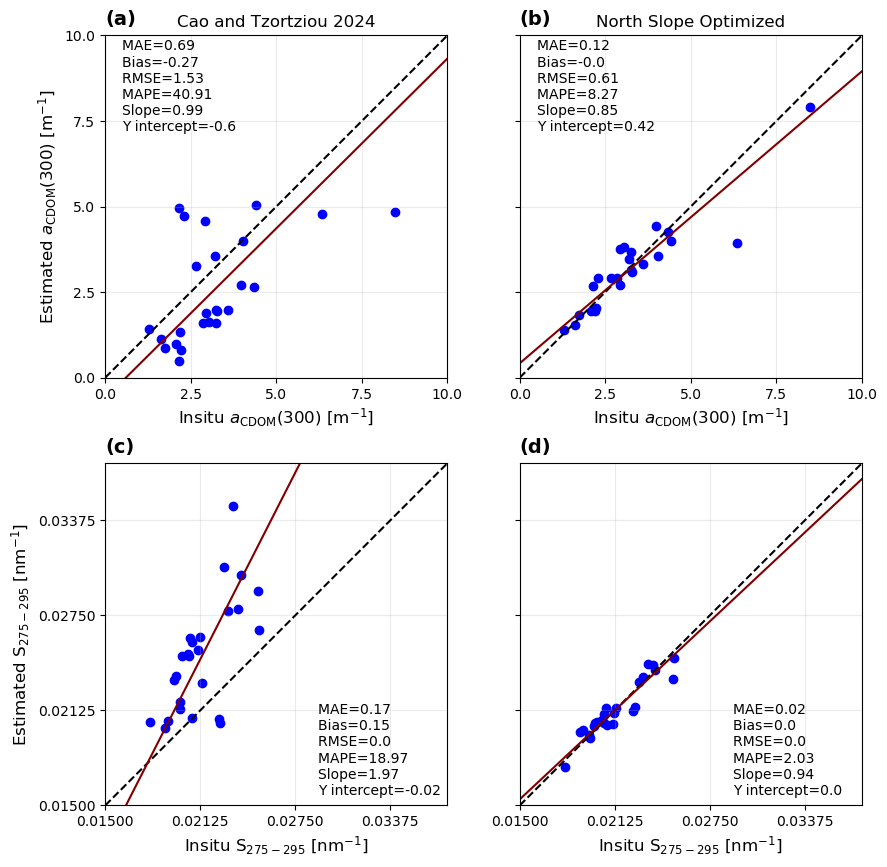

In [10]:
# Define models and data
models_cdom = [cao_cdom, PB_cdom]
model_names_cdom = ["Cao and Tzortziou 2024", "North Slope Optimized"]

models_specslope = [cao_SpecSlope, PB_specslope]
model_names_specslope = ["Cao", "PB"]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex="row", sharey="row")
axs = axs.flatten()

# Row 1: CDOM plots
for ii, ax in enumerate(axs[:2]):
    ax.scatter(PB_data_for_mlr.ag300, models_cdom[ii], c='blue')
    ax.set_title(model_names_cdom[ii], fontsize=12)

    ax.plot(range(0, 11), range(0, 11), c='k', linestyle='--')
    ax.grid(True, alpha=0.25)
    if ii == 0:
        ax.set_ylabel('Estimated $a_\mathrm{CDOM} (300)\ \mathrm{[m^{-1}]}$', fontsize=12)
    ax.set_xlabel('Insitu $a_\mathrm{CDOM} (300)\ \mathrm{[m^{-1}]}$', fontsize=12)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks(np.linspace(0, 10, 5))
    ax.set_yticks(np.linspace(0, 10, 5))
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_ylim(0, 10)
    ax.set_xlim(0, 10)

    stats = regress2(PB_data_for_mlr.ag300, models_cdom[ii], _method_type_2="reduced major axis")
    Y_fit = stats['slope'] * np.linspace(0, 11, 100) + stats['intercept']
    ax.plot(np.linspace(0, 11, 100), Y_fit, c='maroon')

    MAE, bias, RMSE, RMSLE, MAPE, MPD, N = algorithm_performance(models_cdom[ii], PB_data_for_mlr.ag300, rs_scale='linear', insitu_scale='linear')
    ax.text(0.5, 8.5, f'MAE={MAE} \nBias={bias} \nRMSE={RMSE} \nMAPE={MAPE} \nSlope={np.round(stats["slope"],2)} \nY intercept={np.round(stats["intercept"],2)}', va='center')

# Row 2: Spectral slope plots
for ii, ax in enumerate(axs[2:]):
    ax.scatter(PB_data_for_mlr.specslope, models_specslope[ii], c='blue')

    ax.plot(np.arange(0.015, 0.05, 0.001), np.arange(0.015, 0.05, 0.001), c='k', linestyle='--')
    ax.grid(True, alpha=0.25)
    if ii == 0:
        ax.set_ylabel('Estimated $\mathrm{S_{275-295}\ [nm^{-1}]}$', fontsize=12)
    ax.set_xlabel('Insitu $\mathrm{S_{275-295}\ [nm^{-1}]}$', fontsize=12)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks(np.linspace(0.015, 0.04, 5))
    ax.set_yticks(np.linspace(0.015, 0.04, 5))
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_ylim(0.015, 0.0375)
    ax.set_xlim(0.015, 0.0375)

    stats = regress2(PB_data_for_mlr.specslope, models_specslope[ii], _method_type_2="reduced major axis")
    Y_fit = stats['slope'] * np.arange(0.015, 0.05, 0.001) + stats['intercept']
    ax.plot(np.arange(0.015, 0.05, 0.001), Y_fit, c='maroon')

    MAE, bias, RMSE, RMSLE, MAPE, MPD, N = algorithm_performance(models_specslope[ii], PB_data_for_mlr.specslope, rs_scale='linear', insitu_scale='linear')
    ax.text(0.029, 0.0155, f'MAE={MAE} \nBias={bias} \nRMSE={RMSE} \nMAPE={MAPE} \nSlope={np.round(stats["slope"],2)} \nY intercept={np.round(stats["intercept"],2)}', va='bottom')

# Adjust horizontal and vertical spacing
plt.subplots_adjust(wspace=0.15, hspace=0.25)


subplot_labels = ['(a)', '(b)', '(c)', '(d)']
for ax, label in zip(axs, subplot_labels):
    ax.annotate(label, xy=(0, 1.075), xycoords='axes fraction', fontsize=14, fontweight='bold', va='top', ha='left')


plt.savefig(f'{fig_path}/Fig5_model_optimization.png',facecolor='w',bbox_inches='tight', dpi=300)


In [11]:
OLCI_doc = PB_cdom/(np.exp(-15.05 - 33.95 * PB_specslope) + np.exp(-1.502 - 104.3 * PB_specslope))

In [13]:
################################################################################################################################
# ### Calcaulte CDOM with MLR from MSI ###
X = np.log(PB_data_for_mlr.reset_index()[['Rrs443','Rrs490','Rrs560', 'Rrs665']])
y = np.log(PB_data_for_mlr.reset_index()['ag300'])
X = sm.add_constant(X)
cdom_coeffs = []
metrics = {"MAE": [], "Bias": [], "RMSE": [], "RMSLE": [], "MAPE": [], "MPD": []}

# Leave-One-Out Cross-Validation
for i in range(len(PB_data_for_mlr)):
    # Split into training data
    X_train = X.drop(i, axis=0)
    y_train = y.drop(i, axis=0)
    model = sm.OLS(y_train, X_train).fit()
    cdom_coeffs.append(model.params.values)
    MAE, bias, RMSE, RMSLE, MAPE, MPD, N = algorithm_performance(np.exp(model.predict(X.iloc[i])), np.exp(y[i]), rs_scale='linear', insitu_scale='linear')
        # Append metrics
    metrics["MAE"].append(MAE)
    metrics["Bias"].append(bias)
    metrics["RMSE"].append(RMSE)
    metrics["RMSLE"].append(RMSLE)
    metrics["MAPE"].append(MAPE)
    metrics["MPD"].append(MPD)

    
# Average coefficients across folds
msi_cdom_coeffs_avg = np.mean(cdom_coeffs, axis=0).round(5)

PB_cdom_MSI = np.exp(msi_cdom_coeffs_avg[0] +
                    msi_cdom_coeffs_avg[1] * np.log(PB_data_for_mlr.Rrs443) + msi_cdom_coeffs_avg[2] * np.log(PB_data_for_mlr.Rrs490) +
                    msi_cdom_coeffs_avg[3] * np.log(PB_data_for_mlr.Rrs560) + msi_cdom_coeffs_avg[4] * np.log(PB_data_for_mlr.Rrs665))
msi_cdom_coeff_stats = {
    "Mean": np.mean(cdom_coeffs, axis=0).round(5),
    "StdDev": np.std(cdom_coeffs, axis=0).round(5),
    "Min": np.min(cdom_coeffs, axis=0).round(5),
    "Max": np.max(cdom_coeffs, axis=0).round(5),
    "StdErr": (np.std(cdom_coeffs, axis=0) / np.sqrt(len(PB_data_for_mlr))).round(5)
}

# Aggregate metrics
msi_metric_summary = {key: {"Mean": np.mean(values).round(5), "StdDev": np.std(values).round(5)} for key, values in metrics.items()}
msi_metric_summary_df = pd.DataFrame.from_dict(metric_summary, orient='index')

In [14]:
################################################################################################################################
# ### Calcaulte S275-295 with MLR from MSI ###
X = np.log(PB_data_for_mlr.reset_index()[['Rrs443','Rrs490','Rrs560', 'Rrs665']])
y = np.log(PB_data_for_mlr.reset_index()['specslope'])
X = sm.add_constant(X)
slope_coeffs = []
slope_metrics = {"MAE": [], "Bias": [], "RMSE": [], "RMSLE": [], "MAPE": [], "MPD": []}

# Leave-One-Out Cross-Validation
for i in range(len(PB_data_for_mlr)):
    # Split into training data
    X_train = X.drop(i, axis=0)
    y_train = y.drop(i, axis=0)
    model = sm.OLS(y_train, X_train).fit()
    slope_coeffs.append(model.params.values)
    MAE, bias, RMSE, RMSLE, MAPE, MPD, N = algorithm_performance(np.exp(model.predict(X.iloc[i])), np.exp(y[i]), rs_scale='linear', insitu_scale='linear')
        # Append metrics
    slope_metrics["MAE"].append(MAE)
    slope_metrics["Bias"].append(bias)
    slope_metrics["RMSE"].append(RMSE)
    slope_metrics["RMSLE"].append(RMSLE)
    slope_metrics["MAPE"].append(MAPE)
    slope_metrics["MPD"].append(MPD)

    
# Average coefficients across folds
msi_slope_coeffs_avg = np.mean(slope_coeffs, axis=0).round(5)

PB_specslope_MSI = np.exp(msi_slope_coeffs_avg[0] +
                    msi_slope_coeffs_avg[1] * np.log(PB_data_for_mlr.Rrs443) + msi_slope_coeffs_avg[2] * np.log(PB_data_for_mlr.Rrs490) +
                    msi_slope_coeffs_avg[3] * np.log(PB_data_for_mlr.Rrs560) + msi_slope_coeffs_avg[4] * np.log(PB_data_for_mlr.Rrs665))
msi_slope_coeff_stats = {
    "Mean": np.mean(slope_coeffs, axis=0).round(5),
    "StdDev": np.std(slope_coeffs, axis=0).round(5),
    "Min": np.min(slope_coeffs, axis=0).round(5),
    "Max": np.max(slope_coeffs, axis=0).round(5),
    "StdErr": (np.std(slope_coeffs, axis=0) / np.sqrt(len(PB_data_for_mlr))).round(5)
}
# Aggregate metrics
msi_slope_metric_summary = {key: {"Mean": np.mean(values).round(5), "StdDev": np.std(values).round(5)} for key, values in slope_metrics.items()}
msi_slope_metric_summary_df = pd.DataFrame.from_dict(slope_metric_summary, orient='index')

In [15]:
MSI_doc = PB_cdom_MSI/(np.exp(-15.05 - 33.95 * PB_specslope_MSI) + np.exp(-1.502 - 104.3 * PB_specslope_MSI))

In [ ]:
def cdom_calc(olci):
    olci = olci.where((olci.qwip>-0.2) & (olci.qwip<0.2)) # keep only values where QWIP scores are valid
    
    olci = olci.assign(cdom = lambda x: np.exp(cdom_coeffs_avg[0] +
                                                  cdom_coeffs_avg[1] * np.log(x.Rrs443) + cdom_coeffs_avg[2] * np.log(x.Rrs490) +
                                                  cdom_coeffs_avg[3] * np.log(x.Rrs510) + cdom_coeffs_avg[4] * np.log(x.Rrs560) +
                                                  cdom_coeffs_avg[5] * np.log(x.Rrs665)))
    olci['cdom'] = olci['cdom'].where(olci['cdom'] < 100)
  
    olci = olci.assign(S275_295 = lambda x: np.exp(slope_coeffs_avg[0] +
                                                      slope_coeffs_avg[1] * np.log(x.Rrs443) + slope_coeffs_avg[2] * np.log(x.Rrs490) +
                                                      slope_coeffs_avg[3] * np.log(x.Rrs510) + slope_coeffs_avg[4] * np.log(x.Rrs560) +
                                                      slope_coeffs_avg[5] * np.log(x.Rrs665)))

    olci = olci.assign(doc = lambda x: x.cdom/(np.exp(-15.05 - 33.95 * x.S275_295) + np.exp(-1.502 - 104.3 * x.S275_295)))

    return olci

In [ ]:
l2gen20 = xr.open_dataset('/.../PB_l2gen_2020.nc')
l2gen20 = cdom_calc(l2gen20)


l2gen21 = xr.open_dataset('/.../PB_l2gen_2021.nc')
l2gen21 = cdom_calc(l2gen21)


l2gen22 = xr.open_dataset('/.../PB_l2gen_2022.nc')
l2gen22 = cdom_calc(l2gen22)

In [17]:
meta_dict = {'cdom':{'vmin':0, 'vmax':14, 'units': '$\mathrm{[m^{-1}]}$'},
                'doc':{'vmin':0, 'vmax':400, 'units': '[$\mathrm{\mu M}$]'},
                'S275_295':{'vmin':0.01, 'vmax':0.032, 'units': '$\mathrm{[nm^{-1}]}$'},
                'spm':{'vmin':0, 'vmax':50, 'units': 'SPM'}}

In [ ]:
dat = l2gen22.sel(Date=slice("2022-08-24", "2022-08-24")).mean(dim="Date")

titles=['$a_\mathrm{CDOM} (300)$', '$\mathrm{S_{275-295}}$', 'DOC']
text_pos = 0.1
fig, axes = plt.subplots(1, 3, figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()}, sharey=True)
for ii, var in  enumerate(['cdom', 'S275_295', 'doc']):
    ax = axes[ii]
    ax.set_extent([-152.05, -146.5, 69.9, 71], crs=ccrs.PlateCarree())

    # Plot coastline
    PB_coast.plot(ec='k',fc='gray', ax=ax, zorder=1)

    ax.set_aspect(4)
    # ax.set_title(titles[ii], fontsize=16)
    # Gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.75, linestyle=':')
    gl.top_labels = False
    gl.right_labels = False
    if ii > 0:
        gl.left_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator([-152,-150, -148])
    gl.ylocator = mticker.FixedLocator([70, 70.4, 70.8])
    gl.xlabel_style = {'size': 16}
    gl.ylabel_style = {'size': 16}

    if ii == 0: insitu_var = "ag300"
    if ii == 1: insitu_var = "specslope"
    if ii == 2: insitu_var = "doc"
    # Plot data
    cs = ax.pcolormesh(dat.lon, dat.lat, dat[var], vmin = meta_dict[var]['vmin'], vmax=meta_dict[var]['vmax'], cmap="turbo")

    cs = ax.scatter(PBdata[PBdata.index.year == 2022].lon, PBdata[PBdata.index.year == 2022].lat, 75,
                    c=PBdata[PBdata.index.year == 2022][insitu_var],  vmin = meta_dict[var]['vmin'], vmax=meta_dict[var]['vmax'], cmap="turbo", ec='k')

    cax = ax.inset_axes([0, -0.2, 1, 0.05])# Draw the colorbar
    # Create a colorbar
    cbar = fig.colorbar(cs, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=12, rotation=0)
    cbar.set_label(f"{titles[ii]} {meta_dict[var]['units']}", fontsize=12)
    if ii == 1:  # For S275_295 subplot
        cbar.set_ticks([ 0.015, 0.02, 0.025, 0.03])

    # Add river and location labels
    ax.text(-150.4, 70.2, 'Colville', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center')
    ax.text(-149.2, 70.125, 'Kuparuk', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center')
    ax.text(-148, 70, 'Sag', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center', va='center')

    ax.add_geometries(shdf.loc[shdf.fcode.isin([53700, 46006])].geometry, ccrs.PlateCarree(), facecolor="none",
                      edgecolor='lightsteelblue', linewidth=1)
    ax.add_geometries(shdf2.loc[shdf2.fcode.isin([46006])].geometry, ccrs.PlateCarree(), facecolor="none",
                      edgecolor='lightsteelblue', linewidth=1)
    ax.add_geometries(shdf3.loc[shdf3.fcode.isin([46006])].geometry, ccrs.PlateCarree(), facecolor="none",
                      edgecolor='lightsteelblue', linewidth=1)

    ax.scatter(-148.4597, 70.2002, s=150, marker='*', color='firebrick', zorder=10)

    for ii, row in df2022.iterrows():
        if row.station=="24":
            ax.text(row.lon, row.lat-0.06, row.station, c='k', fontsize=14, ha='center', fontweight="bold")
        else:
            ax.text(row.lon, row.lat+0.05, row.station, c='k', fontsize=14, ha='center', fontweight="bold")

plt.subplots_adjust(wspace=0.08)

subplot_labels = ['(a)', '(b)', '(c)']
for ax, label in zip(axes, subplot_labels):
    ax.annotate(label, xy=(0, 1.05), xycoords='axes fraction', fontsize=14, fontweight='bold', va='top', ha='left')

plt.savefig(f'{fig_path}/Fig6_CarbonCycle_componentes_2022_overley.png',facecolor='w',bbox_inches='tight', dpi=300)


In [ ]:
X,Y = np.meshgrid(l2gen21.lat.values, l2gen21.lon.values)
ipixel, irow, icol = match_pixel(X, Y, 70.610100, -144.600200, nbox=3) # staion 9 lat lon
l2gen21.doc[-31:-16,:,:].isel(lat=icol.flatten(), lon=irow.flatten()).mean(skipna=True)

In [ ]:
X,Y = np.meshgrid(l2gen21.lat.values, l2gen21.lon.values)
ipixel, irow, icol = match_pixel(X, Y,70.4160, -144.9345, nbox=3) # staion 8 lat lon
l2gen21.doc[-31:-16,:,:].isel(lat=icol.flatten(), lon=irow.flatten()).mean(skipna=True)

In [ ]:
X,Y = np.meshgrid(l2gen21.lat.values, l2gen21.lon.values)
ipixel, irow, icol = match_pixel(X, Y, 70.1874,	-145.6414, nbox=3) # staion 6 lat lon
l2gen21.doc[-31:-16,:,:].isel(lat=icol.flatten(), lon=irow.flatten()).mean(skipna=True)

In [ ]:
from shapely.geometry import Point, MultiPoint
from shapely.affinity import scale

vals = zip(offshore2022.loc[offshore2022.station != 21].lat,offshore2022.loc[offshore2022.station != 21].lon)
station_points = [Point(lon, lat) for lat, lon in vals]

multi_point = MultiPoint(station_points)
offshore_convex_hull = multi_point.convex_hull.buffer(0.02)
 

def mask_dataset(ds, convex_hull):
    # Flatten latitude and longitude coordinates
    lats = ds['lat'].values
    lons = ds['lon'].values

    # Create a 2D boolean mask for all points inside the convex hull
    mask = np.array([
        convex_hull.contains(Point(lon, lat)) for lat, lon in zip(np.ravel(lats), np.ravel(lons))
    ])
    mask = mask.reshape(lats.shape)  # Reshape mask to match the dataset's lat/lon grid

    return mask

# Apply mask to dat
offshore_mask = mask_dataset(dat, offshore_convex_hull)
offshore_hull = gpd.GeoDataFrame({'geometry': [offshore_convex_hull]}, crs="EPSG:4326")


In [ ]:
for ii,row in offshore2022.loc[offshore2022.station != 21].iterrows():
    print (row.lon,",",row.lat)

In [ ]:
def mask_dataset(ds, polygon):
    # Flatten latitude and longitude coordinates
    lats = ds['lat'].values
    lons = ds['lon'].values

    # Create a 2D boolean mask for all points inside the convex hull
    mask = np.array([
        polygon.contains(Point(lon, lat)) for lat, lon in zip(np.ravel(lats), np.ravel(lons))
    ])
    mask = mask.reshape(lats.shape)  # Reshape mask to match the dataset's lat/lon grid

    return mask
coordinates = [(-151.3553469, 70.5664014), (-151.2454836, 70.4012889), (-150.7785647, 70.4564756), (-150.3226321, 70.4252215), (-150.0589602, 70.4233815), (-149.8612063, 70.4803435),
               (-149.5096438, 70.4693310), (-149.0262453, 70.4233815), (-148.8394778, 70.3883905), (-148.5263674, 70.3219268), (-148.3615725, 70.2774976), (-148.2187502, 70.3219268),
               (-147.9715578, 70.2867616), (-147.8067629, 70.2236837), (-147.6364748, 70.1678659), (-147.3398440, 70.1361688), (-147.0322268, 70.1305701), (-146.8948977, 70.1287035),
               (-146.8196412, 70.2434302), (-147.1382447, 70.2916373), (-147.5557252, 70.3886346), (-147.9841920, 70.4640658), (-148.3851930, 70.4704921), (-149.2036744, 70.5282376),
               (-149.6563112, 70.5755942), (-149.9282228, 70.5655470), (-150.2028810, 70.5618923), (-151.3553469, 70.5664014)]

onshore_polygon = Polygon(coordinates)
onshore_mask = mask_dataset(dat, onshore_polygon)

onshore_polygon = gpd.GeoDataFrame({'geometry': [onshore_polygon]}, crs="EPSG:4326")

In [ ]:
coordinates =  [(-147.1036381, 70.3906121), (-146.9608158, 70.5), (-148.5648197, 70.7), (-149.6909184, 70.76), (-151.4, 70.8),
                             (-151.3059086, 70.65), (-150.4061284, 70.6569329), (-149.4689941, 70.64), (-148.6889648, 70.58), (-147.1036381, 70.3906121)]

offshore_polygon = Polygon(coordinates)
offshore_mask = mask_dataset(dat, offshore_polygon)

offshore_polygon = gpd.GeoDataFrame({'geometry': [offshore_polygon]}, crs="EPSG:4326")

In [ ]:
dat = l2gen22.sel(Date=slice("2022-08-24", "2022-08-24")).mean(dim="Date")

# Adjust the code to set xticks with degree symbols
fig, axes = plt.subplots(3, 2, figsize=(10, 10), sharex=True)
axes = axes.flatten()

dat.cdom[onshore_mask].mean(dim="lat").plot(c='darkblue', ax=axes[0])
axes[0].scatter(onshore2022.lon, onshore2022.ag300, c='k', zorder=10)

dat.cdom[offshore_mask].mean(dim="lat").plot(c='firebrick', ax=axes[1])
axes[1].scatter(offshore2022.loc[offshore2022.station != 21].lon, offshore2022.loc[offshore2022.station != 21].ag300, c='k', zorder=10)

dat.S275_295[onshore_mask].mean(dim="lat").plot(c='darkblue', ax=axes[2])
axes[2].scatter(onshore2022.lon, onshore2022.specslope, c='k')

dat.S275_295[offshore_mask].mean(dim="lat").plot(c='firebrick', ax=axes[3])
axes[3].scatter(offshore2022.loc[offshore2022.station != 21].lon, offshore2022.loc[offshore2022.station != 21].specslope, c='k', zorder=10)

dat.doc[onshore_mask].mean(dim="lat").plot(c='darkblue', ax=axes[4])
axes[4].scatter(onshore2022.lon, onshore2022.doc, c='k', zorder=10)

dat.doc[offshore_mask].mean(dim="lat").plot(c='firebrick', ax=axes[5])
axes[5].scatter(offshore2022.loc[offshore2022.station != 21].lon, offshore2022.loc[offshore2022.station != 21].doc, c='k', zorder=10)

for ii, ax in enumerate(axes):
    ax.set_xlim(-152, -146)
    ax.set_xticks([-152, -150, -148, -146])
    ax.set_xticklabels([f"{abs(tick)}°W" for tick in [-152, -150, -148, -146]], fontsize=12)
    ax.tick_params(axis='y', labelsize=12) 
    if ii > 3:
        ax.set_xlabel("Longitude", fontsize=14)
    else:
        ax.set_xlabel("")
    if ii in [1,3,5]:
        ax.set_ylabel("")
    
axes[0].set_ylabel('$a_\mathrm{CDOM} (300)\ \mathrm{[m^{-1}]}$', fontsize=14)
axes[2].set_ylabel('$\mathrm{S_{275-295}\ [nm^{-1}]}$', fontsize=14)
axes[4].set_ylabel('DOC [$\mu \mathrm{M}$]', fontsize=14)



subplot_labels = ['(a)', '(b)', '(c)', '(d)','(e)','(f)']
for ax, label in zip(axes, subplot_labels):
    ax.annotate(label, xy=(0, 1.075), xycoords='axes fraction', fontsize=14, fontweight='bold', va='top', ha='left')

plt.tight_layout()

# Add inset map
ax_inset = fig.add_axes([0.7, 0.85, 0.3, 0.25], projection=ccrs.PlateCarree())


PB_coast.plot(ec='k',fc='gray', ax=ax_inset, zorder=1)
ax_inset.set_extent([-152.05, -146.5, 70.15, 71], crs=ccrs.PlateCarree())
ax_inset.set_aspect(4)

gl = ax_inset.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.75, linestyle=':')
gl.bottom_labels = False
gl.left_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([-152,-150, -148, -146, -144])
gl.ylocator = mticker.FixedLocator([70.2, 70.5, 70.8])
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}


ax_inset.add_geometries(shdf.loc[shdf.fcode.isin([53700, 46006])].geometry, ccrs.PlateCarree(), facecolor="none",
                    edgecolor='lightsteelblue', linewidth=1)
ax_inset.add_geometries(shdf2.loc[shdf2.fcode.isin([46006])].geometry, ccrs.PlateCarree(), facecolor="none",
                    edgecolor='lightsteelblue', linewidth=1)
ax_inset.add_geometries(shdf3.loc[shdf3.fcode.isin([46006])].geometry, ccrs.PlateCarree(), facecolor="none",
                    edgecolor='lightsteelblue', linewidth=1)

ax_inset.scatter(-148.4597, 70.2002, s=150, marker='*', color='firebrick', zorder=10)

ax_inset.scatter(df2022.lon, df2022.lat, s=50,  c='darkblue', label="2022")

for ii, row in df2022.iterrows():
    if row.station=="24":
        ax_inset.text(row.lon, row.lat+0.07, row.station, c='k', fontsize=12, ha='center', fontweight="bold")
    else:
        ax_inset.text(row.lon, row.lat+0.05, row.station, c='k', fontsize=12, ha='center', fontweight="bold")
         
onshore_polygon.plot(ax=ax_inset, ec='darkblue', fc='none', lw=2)
offshore_polygon.plot(ax=ax_inset, ec='firebrick', fc='none', lw=2)

plt.savefig(f'{fig_path}/Fig7_2022_overlay_onshore_offshore_transects.png',facecolor='w',bbox_inches='tight', dpi=300)


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()}, sharey=True, sharex=True)
axes = axes.flatten()

dat21 = l2gen21.sel(Date=slice("2021-08-01", "2021-08-31")).mean(dim="Date")
dat22 = l2gen22.sel(Date=slice("2022-08-01", "2022-08-31")).mean(dim="Date")

data_dict = {0: dat21, 1: dat21, 2: dat22, 3: dat22}  # Map subplots to datasets
var_dict = {0: 'cdom', 1: 'doc', 2: 'cdom', 3: 'doc'}  # Map subplots to variables
cbar_titles = ["","",'$a_\mathrm{CDOM} (300)\ \mathrm{[m^{-1}]}$', 'DOC [$\mu \mathrm{M}$]']

for jj, ax in enumerate(axes):
    ax.set_extent([-152.05, -144, 69.9, 71], crs=ccrs.PlateCarree())
    PB_coast.plot(ec='k', fc='gray', ax=ax, zorder=1)
    ax.set_aspect(4)

    # Gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.75, linestyle=':')
    gl.top_labels = False
    if jj in [0,2]:
        gl.right_labels = False
    if jj in [1,3]:
        gl.left_labels = False
    if jj in [0,1]:
        gl.bottom_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator([-152, -150, -148, -146, -144])
    gl.ylocator = mticker.FixedLocator([70, 70.4, 70.8])
    gl.xlabel_style = {'size': 16}
    gl.ylabel_style = {'size': 16}

    # Add river and location labels
    ax.text(-150.4, 70.2, 'Colville', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center')
    ax.text(-149.2, 70.125, 'Kuparuk', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center')
    ax.text(-148, 70, 'Sag', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center', va='center')
    ax.scatter(-148.4597, 70.2002, s=150, marker='*', color='firebrick', zorder=10)

    # Add shapefiles
    ax.add_geometries(shdf.loc[shdf.fcode.isin([53700, 46006])].geometry, ccrs.PlateCarree(), facecolor="none", edgecolor='lightsteelblue', linewidth=1)
    ax.add_geometries(shdf2.loc[shdf2.fcode.isin([46006])].geometry, ccrs.PlateCarree(), facecolor="none", edgecolor='lightsteelblue', linewidth=1)
    ax.add_geometries(shdf3.loc[shdf3.fcode.isin([46006])].geometry, ccrs.PlateCarree(), facecolor="none", edgecolor='lightsteelblue', linewidth=1)

    data = data_dict[jj]
    var = var_dict[jj]
    cs = ax.pcolormesh(data.lon, data.lat, data[var], vmin=meta_dict[var]['vmin'], vmax=meta_dict[var]['vmax'], cmap="turbo")
    if jj in [2,3]:
        cax = ax.inset_axes([0, -0.2, 1, 0.05])
        cbar = fig.colorbar(cs, cax=cax, orientation='horizontal')
        cbar.ax.tick_params(labelsize=12, rotation=0)
        cbar.set_label(f"{cbar_titles[jj]}", fontsize=12)

        for _, row in df2022.iterrows():
            ax.scatter(row.lon,row.lat, c='k')
            offset = -0.06 if row.station == "24" else 0.05
            ax.text(row.lon, row.lat-0.06, row.station, c='k', fontsize=14, ha='center', fontweight="bold")
            
    if jj in [0,1]:
        for _, row in df2021.loc[~df2021['station'].str.contains('b', na=False)].iterrows():
            ax.scatter(row.lon,row.lat, c='k')
            ax.text(row.lon, row.lat + 0.05, row.station, c='k', fontsize=14, ha='center', fontweight="bold")

# Add subplot labels
subplot_labels = ['(a)', '(b)', '(c)', '(d)']
for ax, label in zip(axes, subplot_labels):
    ax.annotate(label, xy=(0, 1.05), xycoords='axes fraction', fontsize=14, fontweight='bold', va='top', ha='left')

axes[0].annotate("August 2021", xy=(1, 1.15), xycoords='axes fraction', fontsize=20, va='top', ha='center')
axes[2].annotate("August 2022", xy=(1, 1.15), xycoords='axes fraction', fontsize=20, va='top', ha='center')

# Adjust spacing
fig.subplots_adjust(wspace=0.02, hspace=-0.5) 

plt.savefig(f'{fig_path}/Fig8_CarbonCycle_CDOM_DOC_20221_2022_comp.png',facecolor='w',bbox_inches='tight', dpi=300)

In [ ]:
sag_lon_min = -148.3; sag_lon_max = -147.7
kup_lon_min = -149; kup_lon_max = -148.7
col_lon_min = -151.25; col_lon_max = -150.25

# Define the bounds for each river
col_bounds = {"lon_min": col_lon_min, "lon_max": col_lon_max,
              "lat_min": 70,"lat_max": 70.57}

kup_bounds = {"lon_min": kup_lon_min, "lon_max": kup_lon_max,
              "lat_min": 70, "lat_max": 70.5}

sag_bounds = {"lon_min": sag_lon_min, "lon_max": sag_lon_max,
              "lat_min": 70, "lat_max": 70.425,}

# Create polygons for each river
col_polygon = Polygon([(col_bounds["lon_min"], col_bounds["lat_min"]), (col_bounds["lon_max"], col_bounds["lat_min"]),
                       (col_bounds["lon_max"], col_bounds["lat_max"]), (col_bounds["lon_min"], col_bounds["lat_max"]),])

kup_polygon = Polygon([(kup_bounds["lon_min"], kup_bounds["lat_min"]), (kup_bounds["lon_max"], kup_bounds["lat_min"]),
                       (kup_bounds["lon_max"], kup_bounds["lat_max"]), (kup_bounds["lon_min"], kup_bounds["lat_max"]),])

sag_polygon = Polygon([(sag_bounds["lon_min"], sag_bounds["lat_min"]), (sag_bounds["lon_max"], sag_bounds["lat_min"]),
                       (sag_bounds["lon_max"], sag_bounds["lat_max"]), (sag_bounds["lon_min"], sag_bounds["lat_max"]),])

In [ ]:
def preprocess_discharge_data(file_path, station_code):
    discharge_data = pd.read_csv(file_path, delimiter="\t", skiprows=range(0,27))
    discharge_data = discharge_data.drop(0)
    discharge_data = discharge_data.drop(columns=['agency_cd', 'site_no', 'tz_cd'])
    discharge_data['datetime'] = pd.to_datetime(discharge_data['datetime'])
    discharge_data['datetime'] = discharge_data['datetime'].dt.tz_localize(tz='America/Anchorage', ambiguous=True).dt.tz_convert(tz='UTC')
    discharge_data.set_index('datetime', drop=True, inplace=True)
    discharge_data = discharge_data.rename(columns={station_code + '_00060': 'discharge', station_code + '_00060_cd': 'qa'})
    discharge_data['discharge'] = discharge_data['discharge'].astype(float)
    discharge_data['discharge'] = discharge_data['discharge'] * 0.028317 # convert form cubit feet per s to cubic m per sec
    discharge_data = discharge_data['discharge'].resample('D').mean()
    return discharge_data

sag_discharge = preprocess_discharge_data("/data/home004/jonathan.sherman/projects/Arctic/PB/data/sag_discharge.txt", '1930')
kup_discharge = preprocess_discharge_data("/data/home004/jonathan.sherman/projects/Arctic/PB/data/kuparuk_discharge.txt", '1918')
col_discharge = preprocess_discharge_data("/data/home004/jonathan.sherman/projects/Arctic/PB/data/colville_discharge.txt", '1907')

# Colville scale for the ungauged region
col_discharge = col_discharge * (59756/35897)
# Sag scale for the ungauged region
sag_discharge = sag_discharge * (12580/4791.5)

In [ ]:
col_subset_20 = l2gen20.sel(lon=slice(col_lon_min, col_lon_max), lat=slice(70.57, 70)).resample(Date="8D").mean(skipna=True)
col_subset_21 = l2gen21.sel(lon=slice(col_lon_min, col_lon_max), lat=slice(70.57, 70)).resample(Date="8D").mean(skipna=True)
col_subset_22 = l2gen22.sel(lon=slice(col_lon_min, col_lon_max), lat=slice(70.57, 70)).resample(Date="8D").mean(skipna=True)

kup_subset_20 = l2gen20.sel(lon=slice(kup_lon_min, kup_lon_max), lat=slice(70.5, 70)).resample(Date="8D").mean(skipna=True)
kup_subset_21 = l2gen21.sel(lon=slice(kup_lon_min, kup_lon_max), lat=slice(70.5, 70)).resample(Date="8D").mean(skipna=True)
kup_subset_22 = l2gen22.sel(lon=slice(kup_lon_min, kup_lon_max), lat=slice(70.5, 70)).resample(Date="8D").mean(skipna=True)

sag_subset_20 = l2gen20.sel(lon=slice(sag_lon_min, sag_lon_max), lat=slice(70.425, 70)).resample(Date="8D").mean(skipna=True)
sag_subset_21 = l2gen21.sel(lon=slice(sag_lon_min, sag_lon_max), lat=slice(70.425, 70)).resample(Date="8D").mean(skipna=True)
sag_subset_22 = l2gen22.sel(lon=slice(sag_lon_min, sag_lon_max), lat=slice(70.425, 70)).resample(Date="8D").mean(skipna=True)

In [ ]:
river_colors = {"Colville": "peru", "Kuparuk": "slateblue", "Sag": "steelblue"}
locations = [("col_discharge", "col_subset", "Colville"), ("kup_discharge", "kup_subset", "Kuparuk"), ("sag_discharge", "sag_subset", "Sag")]
years = [2020, 2021, 2022]


fig, axs = plt.subplots(3, 3, figsize=(15, 10), sharey="row", sharex=True)
axs = axs.flatten()

for row_idx, (discharge_name, subset_name, location) in enumerate(locations):
    for col_idx, year in enumerate(years):

        ax = axs[row_idx * 3 + col_idx]

        discharge_data = eval(discharge_name)
        ax.plot(discharge_data.loc[discharge_data.index.year == year].index.dayofyear,
                discharge_data.loc[discharge_data.index.year == year].values,
                c=river_colors[location], linewidth=2)
        ax.set_xlim(100, 280)

        # Secondary y-axis for DOC
        subset_data = eval(f"{subset_name}_{str(year)[-2:]}")
        ax2 = ax.twinx()
        ax2.scatter(subset_data.Date.dt.dayofyear, subset_data.doc.mean(dim=("lat", "lon"), skipna=True), c='m')

        # Third y-axis for S275_295
        ax3 = ax.twinx()
        ax3.scatter(subset_data.Date.dt.dayofyear, subset_data.S275_295.mean(dim=("lat", "lon"), skipna=True), c='k', marker='d')
        
        if col_idx == 2:
            # Adjust third y-axis position only for the last column
            ax3.spines["right"].set_position(("outward", 60))  # Moves third axis outward
            ax3.spines["right"].set_color("k")
            ax2.spines["right"].set_color("m")
        else:
            # Remove the third y-axis spine for other columns
            ax3.spines["right"].set_visible(False)


        # Add titles and labels
        if row_idx == 0: ax.set_title(f"{year}", fontsize=14)
        if col_idx == 0: ax.set_ylabel(f"{location} \nDischarge [$\mathrm{{m^3/s}}$]", fontsize=12)

        # Set y-limits for DOC (ax2)
        if row_idx == 0: ax2.set_ylim(130, 260)
        if row_idx == 1: ax2.set_ylim(50, 550)
        if row_idx == 2: ax2.set_ylim(50, 250)

        # Set y-limits for S275_295 (ax3)
        if row_idx == 0: ax3.set_ylim(0.019, 0.023)
        if row_idx == 1: ax3.set_ylim(0.017, 0.025)
        if row_idx == 2: ax3.set_ylim(0.019, 0.026)

        # Hide extra y-axis labels
        if col_idx != 2:
            ax2.axes.get_yaxis().set_visible(False)
            ax3.axes.get_yaxis().set_visible(False)

        if col_idx == 2:
            ax2.set_ylabel('DOC [$\mu \mathrm{M}$]', fontsize=12, color='m')
            ax2.tick_params(axis='y', colors='m')  # Set y-axis tick labels color to magenta

            ax3.set_ylabel('$\mathrm{S_{275-295}\ [nm^{-1}]}$', fontsize=12, color='k')

        if row_idx == 2: ax.set_xlabel("Month", fontsize=12)

        if row_idx == 0 and col_idx == 1:
            legend_elements = [Line2D([0], [0], color="k", lw=2, label="Discharge"),
                               Line2D([0], [0], marker='o', color='m', linestyle='None', markersize=8, label="DOC"),
                               Line2D([0], [0], marker='d', color='k', linestyle='None', markersize=8, label="$\mathrm{S_{275-295}}$")]
            fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.05), fontsize=14, ncol=3, frameon=True)

fig.tight_layout()

# Add inset map
# ax_inset = fig.add_axes([0.3, -0.45, 0.5, 0.5], projection=ccrs.PlateCarree())
ax_inset = fig.add_axes([0.25, -0.2, 0.5, 0.2], projection=ccrs.PlateCarree())

PB_coast.plot(ec="k", fc="gray", ax=ax_inset, zorder=1)
ax_inset.set_extent([-152.1, -147.5, 70.19, 70.61], crs=ccrs.PlateCarree())
ax_inset.scatter(-148.4597, 70.2002, s=150, marker="*", color="firebrick", zorder=10)

ax_inset.set_aspect(4)

gl = ax_inset.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.75, linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([-152, -150, -148,])
gl.ylocator = mticker.FixedLocator([70.2, 70.4, 70.6])
gl.xlabel_style = {"size": 12}
gl.ylabel_style = {"size": 12}

# Add river and location labels
ax_inset.text(-150.4, 70.225, "Colville", fontsize=12, rotation=70, color="k", fontweight="bold", zorder=10, ha="center")
ax_inset.text(-149, 70.29, "Kuparuk", fontsize=12, rotation=70, color="k", fontweight="bold", zorder=10, ha="center")
ax_inset.text(-148.125, 70.225, "Sag", fontsize=12, rotation=70, color="k", fontweight="bold", zorder=10, ha="center", va="center")

# Add river polygons with matching colors
for polygon, label in zip([col_polygon, kup_polygon, sag_polygon], ["Colville", "Kuparuk", "Sag"]):
    x, y = polygon.exterior.xy  # Get x, y coordinates of the polygon
    ax_inset.fill(x, y, color=river_colors[label], alpha=0.5, label=label, zorder=-1)


ax_inset.add_geometries(shdf.loc[shdf.fcode.isin([53700, 46006])].geometry, ccrs.PlateCarree(), facecolor="none", edgecolor="lightsteelblue", linewidth=1, alpha=0.9)
ax_inset.add_geometries(shdf2.loc[shdf2.fcode.isin([46006])].geometry, ccrs.PlateCarree(), facecolor="none", edgecolor="lightsteelblue", linewidth=1, alpha=0.9)
ax_inset.add_geometries(shdf3.loc[shdf3.fcode.isin([46006])].geometry, ccrs.PlateCarree(), facecolor="none", edgecolor="lightsteelblue", linewidth=1, alpha=0.9)

for ax in axs:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b')) 
    ax.xaxis.set_major_locator(mdates.MonthLocator())


plt.savefig(f'{fig_path}/Fig9_river_discharge_onshore_DOC_S275_295.png',facecolor='w',bbox_inches='tight', dpi=300)

In [ ]:
annual_discharge = {"Colville": (col_discharge.resample("Y").sum() * 86400 / 1e9).values.round(2),
                    "Kuparuk": (kup_discharge.resample("Y").sum() * 86400 / 1e9).values.round(2),
                    "Sag": (sag_discharge.resample("Y").sum() * 86400 / 1e9).values.round(2)}

river_bounds = [(col_lon_min, col_lon_max, "firebrick", "Colville", col_discharge),
                (kup_lon_min, kup_lon_max, "royalblue", "Kuparuk", kup_discharge),
                (sag_lon_min, sag_lon_max, "darkgreen", "Sag", sag_discharge)]
years = [l2gen20, l2gen21, l2gen22]

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for col_idx, (lon_min, lon_max, color, river_name, discharge) in enumerate(river_bounds):
    ax = axs[col_idx]
    for year_idx, dat in enumerate(years):
        dat.doc.sel(lon=slice(lon_min, lon_max), lat=slice(71.5, 70)).mean(dim=('lon', 'Date'), skipna=True).plot(
            ax=ax, label=f"{2020 + year_idx}", c=["violet", "royalblue", "teal"][year_idx], linestyle="-", linewidth=2
        )

        year_discharge = annual_discharge[river_name][year_idx]
        ax.text(
            0.45,
            0.9 - year_idx * 0.075,
            f"{2020 + year_idx} discharge: {year_discharge} $\mathrm{{km^3}}$",
            transform=ax.transAxes,
            fontsize=12,
            color=["violet", "royalblue", "teal"][year_idx],
        )

    ax.set_title(f"{river_name}", fontsize=14)
    ax.set_xlabel("Latitude [\u00b0N]", fontsize=14)
    ax.tick_params(axis="both", labelsize=12)
    ax.set_ylabel("")
    ax.set_ylim(80,520)

    if col_idx == 0:
        ax.set_ylabel("DOC [$\mu \mathrm{M}$]", fontsize=14)

    if col_idx == 1:
        ax.fill_between([70.38, 70.484], 520, color='gray', alpha=0.55)
    if col_idx == 2:
        ax.fill_between([70.18, 70.49], 520, color='gray', alpha=0.55)


# Add legend below the middle panel
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", fontsize=12, ncol=3, bbox_to_anchor=(0.5, -0.075))

fig.tight_layout()

subplot_labels = ['(a)', '(b)', '(c)']
for ii, label in enumerate(subplot_labels):
    axs[ii].annotate(label, xy=(0, 1.075), xycoords='axes fraction', fontsize=14, fontweight='bold', va='top', ha='left')

plt.savefig(f'{fig_path}/Fig10_yearly_DOC_latitudinal_transects.png',facecolor='w',bbox_inches='tight', dpi=300)


In [ ]:
mackenzie = pd.read_excel("/.../Mackenzie_ArcticRedRiver_Version_20240813.xlsx", index_col="date")
mackenzie.index = pd.to_datetime(mackenzie.index)
mackenzie = mackenzie.loc[(mackenzie.index.year>=2000) & (mackenzie.index.year<=2022)]

(mackenzie.discharge.resample("Y").sum()* 86400 / 1e9).mean()
(mackenzie.discharge.resample("Y").sum()* 86400 / 1e9)

In [18]:
def load_bands(files, bands):
    data_dict = {}
    for file in files:
        for band in bands:
            if f"RRS_{band}nm" in file:
                da = rioxarray.open_rasterio(file)
                # Ensure it has lat/lon coordinates by reprojecting if necessary
                da = da.rio.reproject("EPSG:4326")

                fill_value = da.rio.nodata
                if fill_value is not None:
                    da = da.where(da != fill_value, other=float("nan"))
                
                data_dict[f"Rrs{band}"] = da
    
    dataset = xr.Dataset(data_dict)
    
    dataset = dataset.rename({'x': 'lon', 'y': 'lat'}).drop_vars(['band', 'spatial_ref'], errors='ignore')
    
    dataset = dataset.assign(
        cdom=lambda x: np.exp(msi_cdom_coeffs_avg[0] + msi_cdom_coeffs_avg[1] * np.log(x.Rrs443) +
                              msi_cdom_coeffs_avg[2] * np.log(x.Rrs490) +
                              msi_cdom_coeffs_avg[3] * np.log(x.Rrs560) +
                              msi_cdom_coeffs_avg[4] * np.log(x.Rrs665)),
                              
        S275_295=lambda x: np.exp(msi_slope_coeffs_avg[0] + msi_slope_coeffs_avg[1] * np.log(x.Rrs443) +
                                   msi_slope_coeffs_avg[2] * np.log(x.Rrs490) +
                                   msi_slope_coeffs_avg[3] * np.log(x.Rrs560) +
                                   msi_slope_coeffs_avg[4] * np.log(x.Rrs665)),
    )
    
    dataset = dataset.assign(doc=lambda x: x.cdom / (np.exp(-15.05 - 33.95 * x.S275_295) + np.exp(-1.502 - 104.3 * x.S275_295)))
    
    return dataset

bands_to_load = ["443", "490", "560", "665"]

In [ ]:
overpass_files = {
    'T05WPU': glob.glob("/.../*T05WPU*RRS_*nm.TIF"),
    'T05WNU': glob.glob("/.../*T05WNU*RRS_*nm.TIF")
}
datasets = {}
for overpass, files in overpass_files.items():
    datasets[overpass] = load_bands(files, bands_to_load)


### Plot CDOM, SpecSlope and DOC from OLCI and MSI 08-11-2020 ###
fig, axes = plt.subplots(2, 3, figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()}, sharey=True)
fig.suptitle("08/11/2020", fontsize=20, y=0.775, x=0.125)

# First row (figure 1)
dat = l2gen20.sel(Date=slice("2020-08-11", "2020-08-11")).mean(dim="Date")
titles=['$a_\mathrm{CDOM} (300)$', '$\mathrm{S_{275-295}}$', 'DOC']
extent = [-151, -148, 70.1, 70.8]
for ii, var in enumerate(['cdom', 'S275_295', 'doc']):
    ax = axes[0, ii]
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Plot coastline
    PB_coast.plot(ec='k', fc='gray', ax=ax, zorder=1)

    ax.set_aspect(4)
    if ii == 1:
        ax.set_title("OLCI", fontsize=18, y = 1.1)
    # ax.set_title(titles[ii], fontsize=16, y = 1.1)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.75, linestyle=':')

    gl.bottom_labels = False
    gl.right_labels = False  if ii < 2 else True
    if ii > 0:
        gl.left_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator([-150.5, -149.5, -148.5])
    gl.ylocator = mticker.FixedLocator([70.2, 70.4, 70.6])
    gl.xlabel_style = {'size': 16}
    gl.ylabel_style = {'size': 16}

        # Add river and location labels
    ax.text(-150.4, 70.2, 'Colville', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center')
    ax.text(-149, 70.3, 'Kuparuk', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center')
    ax.text(-148.2, 70.2, 'Sag', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center', va='center')

    ax.add_geometries(shdf.loc[shdf.fcode.isin([53700, 46006])].geometry, ccrs.PlateCarree(), facecolor="none",
                      edgecolor='lightsteelblue', linewidth=1)
    ax.add_geometries(shdf2.loc[shdf2.fcode.isin([46006])].geometry, ccrs.PlateCarree(), facecolor="none",
                      edgecolor='lightsteelblue', linewidth=1)
    ax.add_geometries(shdf3.loc[shdf3.fcode.isin([46006])].geometry, ccrs.PlateCarree(), facecolor="none",
                      edgecolor='lightsteelblue', linewidth=1)

    ax.scatter(-148.4597, 70.2002, s=150, marker='*', color='firebrick', zorder=10)

    cs = ax.pcolormesh(dat.lon, dat.lat, dat[var], vmin=meta_dict[var]['vmin'], vmax=meta_dict[var]['vmax'], cmap="turbo")
    ax.scatter(-148.4597, 70.2002, s=150, marker='*', color='firebrick', zorder=10)

nan_mask = ~np.isnan(dat.cdom)
polygons = []
for geom, val in shapes(nan_mask.astype(np.int16), mask=nan_mask, transform=rasterio.transform.from_bounds(*dat.rio.bounds(), dat.rio.width, dat.rio.height)):
    if val == 1:  # This value corresponds to NaN areas in the mask
        polygons.append(shape(geom))

# Create a GeoDataFrame from the polygons
gdf = gpd.GeoDataFrame({"geometry": polygons}, crs=dat.rio.crs)
# Define the CRS you want to set, e.g., EPSG:4326 for WGS84
crs = "EPSG:4326" 

# Second row (figure 2)
for ii, var in enumerate(['cdom', 'S275_295', 'doc']):
    ax = axes[1, ii]
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    PB_coast.plot(ec='k', fc='gray', ax=ax, zorder=1)
    ax.set_aspect(4)
    
    if ii==1:
        ax.set_title("MSI", fontsize=18, y = 1)
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.75, linestyle=':')

    gl.top_labels = False
    gl.right_labels = False if ii < 2 else True
    gl.left_labels = False if ii > 0 else True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator([-150.5, -149.5, -148.5])
    gl.ylocator = mticker.FixedLocator([70.2, 70.4, 70.6])
    gl.xlabel_style = {'size': 16}
    gl.ylabel_style = {'size': 16}

        # Add river and location labels
    ax.text(-150.4, 70.2, 'Colville', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center')
    ax.text(-149, 70.3, 'Kuparuk', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center')
    ax.text(-148.2, 70.2, 'Sag', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center', va='center')

    ax.add_geometries(shdf.loc[shdf.fcode.isin([53700, 46006])].geometry, ccrs.PlateCarree(), facecolor="none",
                      edgecolor='lightsteelblue', linewidth=1)
    ax.add_geometries(shdf2.loc[shdf2.fcode.isin([46006])].geometry, ccrs.PlateCarree(), facecolor="none",
                      edgecolor='lightsteelblue', linewidth=1)
    ax.add_geometries(shdf3.loc[shdf3.fcode.isin([46006])].geometry, ccrs.PlateCarree(), facecolor="none",
                      edgecolor='lightsteelblue', linewidth=1)

    ax.scatter(-148.4597, 70.2002, s=150, marker='*', color='firebrick', zorder=10)

    for tile in datasets.keys():
        datasets[tile] = datasets[tile].rio.write_crs(crs, inplace=True)
        masked_tile = datasets[tile].rio.clip(gdf.geometry, gdf.crs, drop=True)
        # cs = ax.pcolormesh(datasets[tile].lon, datasets[tile].lat, datasets[tile][var][0,:,:], vmin=meta_dict[var]['vmin'], vmax=meta_dict[var]['vmax'], cmap="turbo", zorder=-1)
        cs = ax.pcolormesh(masked_tile.lon, masked_tile.lat, masked_tile[var][0,:,:], vmin=meta_dict[var]['vmin'], vmax=meta_dict[var]['vmax'], cmap="turbo", zorder=-1)

    cax = ax.inset_axes([0, -0.2, 1, 0.05])
    cbar = fig.colorbar(cs, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=12, rotation=0)
    cbar.set_label(f"{titles[ii]} {meta_dict[var]['units']}", fontsize=12)
    ax.scatter(-148.4597, 70.2002, s=150, marker='*', color='firebrick', zorder=10)

plt.subplots_adjust(wspace=0.08, hspace=-0.5)

# Create the axes for TIFF images at the bottom (manually position them)
tiff_ax1 = fig.add_axes([0.125, -0.075, 0.35, 0.3])  
tiff_ax2 = fig.add_axes([0.525, -0.075, 0.35, 0.3])

# Add TIFF images
tiff_paths = ["/.../2020-08-11-00_00_2020-08-11-23_59_Sentinel-3_OLCI_True_color.tiff",
    "/.../2020-08-11-00_00_2020-08-11-23_59_Sentinel-2_L2A_True_color.tiff"]

with rasterio.open(tiff_paths[0]) as src:
    tiff_image = src.read([1, 2, 3])  # Assuming it's RGB
    bounds = src.bounds  # Get bounds (left, bottom, right, top)
    transform = src.transform  # Get the affine transformation
    width = src.width
    height = src.height
tiff_ax1.imshow(tiff_image.transpose(1, 2, 0))
tiff_ax1.axis('off')  # Turn off axis
tiff_ax1.set_title("OLCI True Color", fontsize=18, y = 1)

# Define the coordinates of the red box in lon/lat
polygon_coords = [(-151, 70.2), (-148, 70.2), (-148, 70.8), (-151, 70.8)]

# Convert the polygon's lat/lon coordinates to pixel coordinates using the transform
def lonlat_to_pixel(lon, lat, transform):
    """Convert longitude and latitude to pixel coordinates."""
    col, row = ~transform * (lon, lat)
    return col, row

# Convert each polygon corner to pixel coordinates
pixel_coords = [lonlat_to_pixel(lon, lat, transform) for lon, lat in polygon_coords]

# Create a Polygon patch using the pixel coordinates and add it to the image plot
polygon_patch = mpatches.Polygon(pixel_coords, closed=True, edgecolor='red', facecolor='none', lw=2)
tiff_ax1.add_patch(polygon_patch)

with rasterio.open(tiff_paths[1]) as src:
    tiff_image = src.read([1, 2, 3])
    bounds = src.bounds  # Get bounds (left, bottom, right, top)
    transform = src.transform  # Get the affine transformation
    width = src.width
    height = src.height
tiff_ax2.imshow(tiff_image.transpose(1, 2, 0))
tiff_ax2.axis('off')  # Turn off axis
tiff_ax2.set_title("MSI True Color", fontsize=18, y = 1)

# Convert each polygon corner to pixel coordinates
pixel_coords = [lonlat_to_pixel(lon, lat, transform) for lon, lat in polygon_coords]

# Create a Polygon patch using the pixel coordinates and add it to the image plot
polygon_patch =  mpatches.Polygon(pixel_coords, closed=True, edgecolor='red', facecolor='none', lw=2)
tiff_ax2.add_patch(polygon_patch)

plt.savefig(f'{fig_path}/Fig11_OLCI_MSI_Carbon_cycle_comp_20200811.png',facecolor='w',bbox_inches='tight', dpi=300)

In [ ]:
overpass_files = {
    'T05WPU': glob.glob("/.../20220824/*T05WPU*RRS_*nm.TIF"),
    'T05WNU': glob.glob("/.../20220824/*T05WNU*RRS_*nm.TIF"),
    'T06WVD': glob.glob("/.../20220824/*T06WVD*RRS_*nm.TIF")
}
datasets = {}
for overpass, files in overpass_files.items():
    datasets[overpass] = load_bands(files, bands_to_load)


### Plot CDOM, SpecSlope and DOC from OLCI and MSI 08-11-2020 ###
fig, axes = plt.subplots(2, 3, figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()}, sharey=True)
fig.suptitle("08/24/2022", fontsize=20, y=0.775, x=0.125)

# First row (figure 1)
dat = l2gen22.sel(Date=slice("2022-08-24", "2022-08-24")).mean(dim="Date")
titles=['$a_\mathrm{CDOM} (300)$', '$\mathrm{S_{275-295}}$', 'DOC']
extent = [-151, -148, 70.1, 70.8]
for ii, var in enumerate(['cdom', 'S275_295', 'doc']):
    ax = axes[0, ii]
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Plot coastline
    PB_coast.plot(ec='k', fc='gray', ax=ax, zorder=1)

    ax.set_aspect(4)
    if ii == 1:
        ax.set_title("OLCI", fontsize=18, y = 1.1)
    # ax.set_title(titles[ii], fontsize=16, y = 1.1)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.75, linestyle=':')

    gl.bottom_labels = False
    gl.right_labels = False  if ii < 2 else True
    if ii > 0:
        gl.left_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator([-150.5, -149.5, -148.5])
    gl.ylocator = mticker.FixedLocator([70.2, 70.4, 70.6])
    gl.xlabel_style = {'size': 16}
    gl.ylabel_style = {'size': 16}

        # Add river and location labels
    ax.text(-150.4, 70.2, 'Colville', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center')
    ax.text(-149, 70.3, 'Kuparuk', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center')
    ax.text(-148.2, 70.2, 'Sag', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center', va='center')

    ax.add_geometries(shdf.loc[shdf.fcode.isin([53700, 46006])].geometry, ccrs.PlateCarree(), facecolor="none",
                      edgecolor='lightsteelblue', linewidth=1)
    ax.add_geometries(shdf2.loc[shdf2.fcode.isin([46006])].geometry, ccrs.PlateCarree(), facecolor="none",
                      edgecolor='lightsteelblue', linewidth=1)
    ax.add_geometries(shdf3.loc[shdf3.fcode.isin([46006])].geometry, ccrs.PlateCarree(), facecolor="none",
                      edgecolor='lightsteelblue', linewidth=1)

    ax.scatter(-148.4597, 70.2002, s=150, marker='*', color='firebrick', zorder=10)

    cs = ax.pcolormesh(dat.lon, dat.lat, dat[var], vmin=meta_dict[var]['vmin'], vmax=meta_dict[var]['vmax'], cmap="turbo")

    if ii == 0: insitu_var = "ag300"
    if ii == 1: insitu_var = "specslope"
    if ii == 2: insitu_var = "doc"

    cs = ax.scatter(PBdata[PBdata.index.year == 2022].lon, PBdata[PBdata.index.year == 2022].lat, 75,
                    c=PBdata[PBdata.index.year == 2022][insitu_var],  vmin = meta_dict[var]['vmin'], vmax=meta_dict[var]['vmax'], cmap="turbo", ec='k')
    
    ax.scatter(-148.4597, 70.2002, s=150, marker='*', color='firebrick', zorder=10)

nan_mask = ~np.isnan(dat.cdom)
polygons = []
for geom, val in shapes(nan_mask.astype(np.int16), mask=nan_mask, transform=rasterio.transform.from_bounds(*dat.rio.bounds(), dat.rio.width, dat.rio.height)):
    if val == 1:  # This value corresponds to NaN areas in the mask
        polygons.append(shape(geom))

# Create a GeoDataFrame from the polygons
gdf = gpd.GeoDataFrame({"geometry": polygons}, crs=dat.rio.crs)
# Define the CRS you want to set, e.g., EPSG:4326 for WGS84
crs = "EPSG:4326" 

# Second row (figure 2)
for ii, var in enumerate(['cdom', 'S275_295', 'doc']):
    ax = axes[1, ii]
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    PB_coast.plot(ec='k', fc='gray', ax=ax, zorder=1)
    ax.set_aspect(4)
    
    if ii==1:
        ax.set_title("MSI", fontsize=18, y = 1)
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.75, linestyle=':')

    gl.top_labels = False
    gl.right_labels = False if ii < 2 else True
    gl.left_labels = False if ii > 0 else True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator([-150.5, -149.5, -148.5])
    gl.ylocator = mticker.FixedLocator([70.2, 70.4, 70.6])
    gl.xlabel_style = {'size': 16}
    gl.ylabel_style = {'size': 16}

        # Add river and location labels
    ax.text(-150.4, 70.2, 'Colville', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center')
    ax.text(-149, 70.3, 'Kuparuk', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center')
    ax.text(-148.2, 70.2, 'Sag', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center', va='center')

    ax.add_geometries(shdf.loc[shdf.fcode.isin([53700, 46006])].geometry, ccrs.PlateCarree(), facecolor="none",
                      edgecolor='lightsteelblue', linewidth=1)
    ax.add_geometries(shdf2.loc[shdf2.fcode.isin([46006])].geometry, ccrs.PlateCarree(), facecolor="none",
                      edgecolor='lightsteelblue', linewidth=1)
    ax.add_geometries(shdf3.loc[shdf3.fcode.isin([46006])].geometry, ccrs.PlateCarree(), facecolor="none",
                      edgecolor='lightsteelblue', linewidth=1)

    ax.scatter(-148.4597, 70.2002, s=150, marker='*', color='firebrick', zorder=10)

    for tile in datasets.keys():
        datasets[tile] = datasets[tile].rio.write_crs(crs, inplace=True)
        masked_tile = datasets[tile].rio.clip(gdf.geometry, gdf.crs, drop=True)
        # cs = ax.pcolormesh(datasets[tile].lon, datasets[tile].lat, datasets[tile][var][0,:,:], vmin=meta_dict[var]['vmin'], vmax=meta_dict[var]['vmax'], cmap="turbo", zorder=-1)
        cs = ax.pcolormesh(masked_tile.lon, masked_tile.lat, masked_tile[var][0,:,:], vmin=meta_dict[var]['vmin'], vmax=meta_dict[var]['vmax'], cmap="turbo", zorder=-1)
    
    if ii == 0: insitu_var = "ag300"
    if ii == 1: insitu_var = "specslope"
    if ii == 2: insitu_var = "doc"
    cs = ax.scatter(PBdata[PBdata.index.year == 2022].lon, PBdata[PBdata.index.year == 2022].lat, 75,
                    c=PBdata[PBdata.index.year == 2022][insitu_var],  vmin = meta_dict[var]['vmin'], vmax=meta_dict[var]['vmax'], cmap="turbo", ec='k')

    cax = ax.inset_axes([0, -0.2, 1, 0.05])
    cbar = fig.colorbar(cs, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=12, rotation=0)
    cbar.set_label(f"{titles[ii]} {meta_dict[var]['units']}", fontsize=12)
    ax.scatter(-148.4597, 70.2002, s=150, marker='*', color='firebrick', zorder=10)

plt.subplots_adjust(wspace=0.08, hspace=-0.5)

# Create the axes for TIFF images at the bottom (manually position them)
tiff_ax1 = fig.add_axes([0.125, -0.075, 0.35, 0.3])  
tiff_ax2 = fig.add_axes([0.525, -0.075, 0.35, 0.3])

# Add TIFF images
tiff_paths = ["/.../2022-08-24-00_00_2022-08-24-23_59_Sentinel-3_OLCI_True_color.tiff",
    "/.../2022-08-24-00_00_2022-08-24-23_59_Sentinel-2_L2A_True_color.tiff"]

with rasterio.open(tiff_paths[0]) as src:
    tiff_image = src.read([1, 2, 3])  # Assuming it's RGB
    bounds = src.bounds  # Get bounds (left, bottom, right, top)
    transform = src.transform  # Get the affine transformation
    width = src.width
    height = src.height
tiff_ax1.imshow(tiff_image.transpose(1, 2, 0))
tiff_ax1.axis('off')  # Turn off axis
tiff_ax1.set_title("OLCI True Color", fontsize=18, y = 1)

# Define the coordinates of the red box in lon/lat
polygon_coords = [(-151, 70.2), (-148, 70.2), (-148, 70.8), (-151, 70.8)]

# Convert the polygon's lat/lon coordinates to pixel coordinates using the transform
def lonlat_to_pixel(lon, lat, transform):
    """Convert longitude and latitude to pixel coordinates."""
    col, row = ~transform * (lon, lat)
    return col, row

# Convert each polygon corner to pixel coordinates
pixel_coords = [lonlat_to_pixel(lon, lat, transform) for lon, lat in polygon_coords]

# Create a Polygon patch using the pixel coordinates and add it to the image plot
polygon_patch = mpatches.Polygon(pixel_coords, closed=True, edgecolor='red', facecolor='none', lw=2)
tiff_ax1.add_patch(polygon_patch)

with rasterio.open(tiff_paths[1]) as src:
    tiff_image = src.read([1, 2, 3])
    bounds = src.bounds  # Get bounds (left, bottom, right, top)
    transform = src.transform  # Get the affine transformation
    width = src.width
    height = src.height
tiff_ax2.imshow(tiff_image.transpose(1, 2, 0))
tiff_ax2.axis('off')  # Turn off axis
tiff_ax2.set_title("MSI True Color", fontsize=18, y = 1)

# Convert each polygon corner to pixel coordinates
pixel_coords = [lonlat_to_pixel(lon, lat, transform) for lon, lat in polygon_coords]

# Create a Polygon patch using the pixel coordinates and add it to the image plot
polygon_patch =  mpatches.Polygon(pixel_coords, closed=True, edgecolor='red', facecolor='none', lw=2)
tiff_ax2.add_patch(polygon_patch)

plt.savefig(f'{fig_path}/Fig12_OLCI_MSI_Carbon_cycle_comp_20220824_w_insitu.png',facecolor='w',bbox_inches='tight', dpi=300)


In [ ]:
overpass_files = {
    'T05WPU': glob.glob("/.../20220804/*T05WPU*RRS_*nm.TIF"),
}
datasets = {}
for overpass, files in overpass_files.items():
    datasets[overpass] = load_bands(files, bands_to_load)

In [ ]:
from osgeo import gdal, osr
from pyproj import Transformer

# === Open file ===
tif_path = "/.../AVIRIS_Aug2022/mosaic_bands.tif"
img = gdal.Open(tif_path)
ncols, nrows = img.RasterXSize, img.RasterYSize

# === Get GeoTransform and Projection
geotransform = img.GetGeoTransform()
projection = img.GetProjection()

# === Create coordinate arrays
x0, dx, _, y0, _, dy = geotransform
cols, rows = img.RasterXSize, img.RasterYSize

# Create x and y index arrays
x_indices = np.arange(cols)
y_indices = np.arange(rows)

# Compute coordinates in image projection
x_coords = x0 + x_indices * dx
y_coords = y0 + y_indices * dy

# Create full meshgrid of projected coordinates
xx, yy = np.meshgrid(x_coords, y_coords, indexing='xy')

# === Set up transformation to WGS84 lat/lon
source = osr.SpatialReference()
source.ImportFromWkt(projection)

target = osr.SpatialReference()
target.ImportFromEPSG(4326)  # WGS84

transform = osr.CoordinateTransformation(source, target)

# Flatten, transform, and reshape back
flat_xx = xx.flatten()
flat_yy = yy.flatten()
lonlat = np.array(transform.TransformPoints(np.column_stack((flat_xx, flat_yy))))
lon = lonlat[:, 1].reshape(xx.shape)
lat = lonlat[:, 0].reshape(yy.shape)

# === Read band descriptions (wavelengths) ===
band_wavelengths = [float(img.GetRasterBand(i+1).GetDescription().split()[0]) for i in range(img.RasterCount)]
band_numbers = list(range(1, len(band_wavelengths) + 1))

# === Select band numbers for Rrs computation
wavelengths_of_interest = [443, 447, 470, 487, 490, 510, 550, 559, 560, 567, 600, 665, 677, 850, 860, 1650, 2190, 2235]
selected_band_numbers = [
    band_numbers[np.argmin(np.abs(np.array(band_wavelengths) - w))] for w in wavelengths_of_interest
]

# === Load Rrs bands and convert to reflectance
def get_band(b, ds):
    return ds.GetRasterBand(b).ReadAsArray().astype(np.float32)

rrs = np.array([get_band(b, img) for b in selected_band_numbers])
rrs[rrs == -9999.] = np.nan
rrs /= math.pi

# === Unpack specific bands by wavelength
Rrs443, Rrs447, Rrs470, Rrs487, Rrs490, Rrs510, Rrs550, Rrs559, Rrs560, Rrs567, Rrs600, Rrs665, Rrs677, Rrs850, Rrs860, Rrs1650, Rrs2190, Rrs2235 = rrs

# === Water mask
water = (((Rrs550 - Rrs2190) / (Rrs550 + Rrs2190)) > 0) & (((Rrs850 - Rrs600) / (Rrs850 + Rrs600)) < 0.1)
for arr in [Rrs443, Rrs490, Rrs510, Rrs560, Rrs665]:
    arr[~water] = np.nan
# === Cloud mask
cloud_mask = ((Rrs447 > 0.06) & (Rrs2235 > 0.1) & (((Rrs487 - Rrs567) / (Rrs487 + Rrs567)) < -0.15))
for arr in [Rrs443, Rrs490, Rrs510, Rrs560, Rrs665]:
    arr[cloud_mask] = np.nan

# === CDOM
cdom_AVIRIS = np.exp(cdom_coeffs_avg[0] +
              cdom_coeffs_avg[1] * np.log(Rrs443) + cdom_coeffs_avg[2] * np.log(Rrs490) +
              cdom_coeffs_avg[3] * np.log(Rrs510) + cdom_coeffs_avg[4] * np.log(Rrs560) +
              cdom_coeffs_avg[5] * np.log(Rrs665))
cdom_AVIRIS[cdom_AVIRIS > 100] = np.nan

# === Spectral slope
specslope_AVIRIS = np.exp(slope_coeffs_avg[0] +
                   slope_coeffs_avg[1] * np.log(Rrs443) + slope_coeffs_avg[2] * np.log(Rrs490) +
                   slope_coeffs_avg[3] * np.log(Rrs510) + slope_coeffs_avg[4] * np.log(Rrs560) +
                   slope_coeffs_avg[5] * np.log(Rrs665))

# === DOC
doc_AVIRIS = cdom_AVIRIS / (np.exp(-15.05 - 33.95 * specslope_AVIRIS) + np.exp(-1.502 - 104.3 * specslope_AVIRIS))

red = Rrs677
green = Rrs559
blue = Rrs470

rgb = np.dstack((red, green, blue))
rgb[rgb<0] = np.nan


def std_stretch(band, n_std=1):
    """Apply standard deviation stretch to a single band."""
    band = np.ma.masked_invalid(band)
    mean = band.mean()
    std = band.std()
    lower = mean - n_std * std
    upper = mean + n_std * std
    stretched = np.clip(band, lower, upper)
    # Normalize to 0–1
    stretched = (stretched - lower) / (upper - lower)
    return stretched#.filled(0)  # replace masked with 0 (or use np.nan if preferred)


# Apply per-band stretch
r_stretched = std_stretch(red)
g_stretched = std_stretch(green)
b_stretched = std_stretch(blue)

# Re-stack
rgb_stretched = np.dstack((r_stretched, g_stretched, b_stretched))
rgb_stretched = exposure.adjust_gamma(rgb_stretched, gamma=1.1)


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()})
titles=["MSI Aug. 4 2022", "AVIRIS-NG Aug. 3-4 2022"]
# Flatten the axes array
axes = axes.flatten()

var = 'doc'
for ii, ax in enumerate(axes):
    ax.set_extent([-150.3,-149.2, 70.4, 70.6], crs=ccrs.PlateCarree())  # Set extent

    if ii == 0: PB_coast.to_crs("EPSG:4326").plot(ec='k',fc='gray', ax=ax, zorder=-1)

    # Gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.75, linestyle=':')
    gl.top_labels = False
    gl.left_labels = (ii == 0)
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator([-150.2, -149.8, -149.4])
    gl.ylocator = mticker.FixedLocator([70.45, 70.5, 70.55])
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}

    # Set subplot title if needed
    ax.set_title(titles[ii], fontsize=16)

    ax.set_aspect(5)

crs = "EPSG:4326" 
for tile in datasets.keys():
    datasets[tile] = datasets[tile].rio.write_crs(crs, inplace=True)
    cs = axes[0].pcolormesh(datasets[tile].lon,  datasets[tile].lat,  datasets[tile][var][0,:,:], vmin=meta_dict[var]['vmin'], vmax=meta_dict[var]['vmax'], cmap="turbo", zorder=-1)
##############################

# AOI mask and bounding box
mask = (
    (lon >= -150.3) & (lon <= -149.2) &
    (lat >= 70.4) & (lat <= 70.6)
)
row_inds, col_inds = np.where(mask)

row_min, row_max = row_inds.min(), row_inds.max()
col_min, col_max = col_inds.min(), col_inds.max()

# Crop arrays
rgb_crop = rgb_stretched[row_min:row_max+1, col_min:col_max+1, :]
doc_crop = doc_AVIRIS[row_min:row_max+1, col_min:col_max+1]
lat_crop = lat[row_min:row_max+1, col_min:col_max+1]
lon_crop = lon[row_min:row_max+1, col_min:col_max+1]

# Build RGBA array for pcolormesh
rgba_crop = np.concatenate([rgb_crop, np.ones((*rgb_crop.shape[:2], 1))], axis=-1)  # add alpha
rgba_crop = np.clip(rgba_crop, 0, 1)  # <--- IMPORTANT
rgba_flat = rgba_crop.reshape(-1, 4)

# Dummy z array for pcolormesh
dummy_z = np.nanmean(rgb_crop, axis=2)

# Plot RGB as colored pcolormesh
ax.pcolormesh(
    lon_crop, lat_crop, dummy_z,
    color=rgba_flat,
    shading='auto',
    transform=ccrs.PlateCarree(),
    zorder=0
)

# Plot DOC overlay on top
p = ax.pcolormesh(
    lon_crop, lat_crop, doc_crop,
    cmap="turbo", vmin=0, vmax=400,
    shading="auto",
    transform=ccrs.PlateCarree(),
    zorder=1
)

    
cax = axes[1].inset_axes([1.025, 0, 0.05, 1])
cbar = fig.colorbar(cs, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=12, rotation=0)
cbar.set_label(f"DOC {meta_dict['doc']['units']}", fontsize=12)

plt.subplots_adjust(wspace=0.05)

plt.savefig(f'{fig_path}/Fig13_MSI_AVIRIS_DOC_20220804.png',facecolor='w',bbox_inches='tight', dpi=300)

In [ ]:
# === Define AOIs ===
rectangles = [
    {'name': 'Sagavanirktok', 'lon_min': -149.2, 'lon_max': -148.775, 'lat_min': 70.395, 'lat_max': 70.6},
    {'name': 'Kuparuk',       'lon_min': -150.3, 'lon_max': -149.925, 'lat_min': 70.386, 'lat_max': 70.6},
]

# Create the figure and GridSpec layout
fig = plt.figure(figsize=(20, 20))
gs = GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 0.05], width_ratios=[1, 1])
projection = ccrs.PlateCarree()

# First subplot (True Color - spanning two columns)
ax1 = fig.add_subplot(gs[0, :], projection=projection)


# Add gridlines
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=1, color='gray', alpha=0.75, linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}

# === Define bounds for imshow ===
extent = [lon.min(), lon.max(), lat.min(), lat.max()]

# === Plot image ===
# Dummy Z just for shape
dummy_z = np.nanmean(rgb_stretched, axis=2)

# Flatten RGBA
rgba = np.concatenate([rgb_stretched, np.ones((*rgb_stretched.shape[:2], 1))], axis=-1)
rgba = np.clip(rgba, 0, 1)
rgba_flat = rgba.reshape(-1, 4)

# Use pcolormesh for georeferenced RGB
ax1.pcolormesh(
    lon, lat, dummy_z,
    color=rgba_flat,
    shading='auto',
    transform=ccrs.PlateCarree(),
    zorder=0
)


# Add rectangle overlays
for rect in rectangles:
    ax1.add_patch(Rectangle(
        (rect['lon_min'], rect['lat_min']),
        rect['lon_max'] - rect['lon_min'],
        rect['lat_max'] - rect['lat_min'],
        linewidth=2, edgecolor='r', facecolor='none', zorder=5
    ))

ax1.set_extent([-150.325, -148.7, 70.38, 70.8], crs=projection)
ax1.set_aspect(2)

# === Bottom Left and Right Panels (AOIs) ===
ax2 = fig.add_subplot(gs[1, 0], projection=projection)
ax2.set_aspect(2)
ax3 = fig.add_subplot(gs[1, 1], projection=projection, sharey=ax2)
ax3.set_aspect(2)

axes = [ax2, ax3]
for ax, rect in zip(axes, [rectangles[1], rectangles[0]]):  # Kuparuk, then Sagavanirktok

    # AOI mask and bounding box
    mask = (
        (lon >= rect['lon_min']) & (lon <= rect['lon_max']) &
        (lat >= rect['lat_min']) & (lat <= rect['lat_max'])
    )
    row_inds, col_inds = np.where(mask)
    if len(row_inds) == 0 or len(col_inds) == 0:
        continue

    row_min, row_max = row_inds.min(), row_inds.max()
    col_min, col_max = col_inds.min(), col_inds.max()

    # Crop arrays
    rgb_crop = rgb_stretched[row_min:row_max+1, col_min:col_max+1, :]
    doc_crop = doc_AVIRIS[row_min:row_max+1, col_min:col_max+1]
    lat_crop = lat[row_min:row_max+1, col_min:col_max+1]
    lon_crop = lon[row_min:row_max+1, col_min:col_max+1]

    # Build RGBA array for pcolormesh
    rgba_crop = np.concatenate([rgb_crop, np.ones((*rgb_crop.shape[:2], 1))], axis=-1)  # add alpha
    rgba_crop = np.clip(rgba_crop, 0, 1)
    rgba_flat = rgba_crop.reshape(-1, 4)

    # Dummy z array for pcolormesh
    dummy_z = np.nanmean(rgb_crop, axis=2)

    # Plot RGB as colored pcolormesh
    ax.pcolormesh(
        lon_crop, lat_crop, dummy_z,
        color=rgba_flat,
        shading='auto',
        transform=ccrs.PlateCarree(),
        zorder=0
    )

    # Plot DOC overlay on top
    p = ax.pcolormesh(
        lon_crop, lat_crop, doc_crop,
        cmap="turbo", vmin=0, vmax=400,
        shading="auto",
        transform=ccrs.PlateCarree(),
        zorder=1
    )

    # Set extent
    ax.set_extent([rect['lon_min'], rect['lon_max'],
                   rect['lat_min'], rect['lat_max']], crs=projection)

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.75, linestyle=':')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 16}
    gl.ylabel_style = {'size': 16}

# ax2.set_extent([-150.3, -149.925, 70.386, 70.6], crs=ccrs.PlateCarree())
# ax3.set_extent([-149.2, -148.75, 70.395, 70.6], crs=ccrs.PlateCarree())

# Add a horizontal color bar below the second row
cbar_ax = fig.add_subplot(gs[2, :])  # The color bar spans both columns
cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal', extend='max')
cbar.set_label(f"DOC {meta_dict['doc']['units']}", fontsize=14)
cbar.ax.tick_params(labelsize=14)

# Adjust layout
plt.subplots_adjust(hspace=0.1) 
plt.savefig(f'{fig_path}/Fig14_AVIRIS_DOC_zoom_in.png',facecolor='w',bbox_inches='tight', dpi=300)

In [ ]:
titles=['C2RCC', 'Aquaverse']
text_pos = 0.1
fig, axes = plt.subplots(1, 2, figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()}, sharey=True)
for ii,ax in enumerate(axes):
    ax.set_extent([-152.05, -146.5, 69.9, 71], crs=ccrs.PlateCarree())
    # Plot coastline
    PB_coast.plot(ec='k',fc='gray', ax=ax, zorder=1)

    ax.set_aspect(4)
    # ax.set_title(titles[ii], fontsize=16)
    # Gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.75, linestyle=':')
    gl.top_labels = False
    gl.right_labels = False
    if ii > 0:
        gl.left_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator([-152,-150, -148])
    gl.ylocator = mticker.FixedLocator([70, 70.4, 70.8])
    gl.xlabel_style = {'size': 16}
    gl.ylabel_style = {'size': 16}

    # Add river and location labels
    ax.text(-150.4, 70.2, 'Colville', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center')
    ax.text(-149.2, 70.125, 'Kuparuk', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center')
    ax.text(-148, 70, 'Sag', fontsize=12, rotation=70, color='k', fontweight='bold', zorder=10, ha='center', va='center')

    ax.add_geometries(shdf.loc[shdf.fcode.isin([53700, 46006])].geometry, ccrs.PlateCarree(), facecolor="none",
                      edgecolor='lightsteelblue', linewidth=1)
    ax.add_geometries(shdf2.loc[shdf2.fcode.isin([46006])].geometry, ccrs.PlateCarree(), facecolor="none",
                      edgecolor='lightsteelblue', linewidth=1)
    ax.add_geometries(shdf3.loc[shdf3.fcode.isin([46006])].geometry, ccrs.PlateCarree(), facecolor="none",
                      edgecolor='lightsteelblue', linewidth=1)

    ax.scatter(-148.4597, 70.2002, s=150, marker='*', color='firebrick', zorder=10)
    ax.set_title(titles[ii], fontsize=14)

plt.subplots_adjust(wspace=0.08)

subplot_labels = ['(a)', '(b)']
for ax, label in zip(axes, subplot_labels):
    ax.annotate(label, xy=(0, 1.05), xycoords='axes fraction', fontsize=14, fontweight='bold', va='top', ha='left')



c2rcc = xr.open_dataset('/.../S2B_L2_20200811T215529_N0209_R029_T05WPU_20200811T233354_C2RCC.nc')
c2rcc = c2rcc.where(c2rcc>0)
cs = axes[0].pcolormesh(c2rcc.lon, c2rcc.lat, c2rcc.rrs_B1, vmin=0, vmax=0.0175, cmap="jet", zorder=-1)


overpass_files = glob.glob("/.../*T05WPU*RRS_*nm.TIF")
aquaverse = load_bands(overpass_files, bands_to_load)

aquaverse["Rrs443"] = aquaverse.Rrs443.where(aquaverse.Rrs443<0.019)
cs= axes[1].pcolormesh(aquaverse.lon, aquaverse.lat, aquaverse.Rrs443[0,:,:], vmin=0, vmax=0.0175, cmap="jet", zorder=-1)

cax = axes[0].inset_axes([0.5, -0.15, 1, 0.05])# Draw the colorbar
# Create a colorbar
cbar = fig.colorbar(cs, cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=12, rotation=0)
cbar.set_label("$\mathrm{R_{rs}(443) [sr^{-1}}]$", fontsize=12)

plt.savefig(f'{fig_path}/SuppFig3_MSI_C2RCC_Aquaverse_Rrs443.png',facecolor='w',bbox_inches='tight', dpi=300)

In [ ]:
from scipy.stats import pearsonr

x_data = PBdata.specslope
y_data = PBdata.ag300 / (PBdata.doc / 10000)

r_value, p_value = pearsonr(x_data, y_data)

n_samples = len(x_data)
print(f"Pearson's r: {r_value:.2f}")
print(f"p-value: {p_value:.3e}")
print(f"Sample Size (N): {n_samples}")

if p_value < 0.001:
    significance = "highly significant"
elif p_value < 0.05:
    significance = "significant"
else:
    significance = "not significant"

print(f"The correlation is {significance}.")
from scipy.stats import spearmanr

rho, p_value = spearmanr(x_data, y_data)
print(f"Spearman's rho: {rho:.2f}, p-value: {p_value:.1e}")


x_vals = np.arange(0.01, 0.05, 0.000005)
fitted_values = np.array([np.exp(-15.05 - 33.95 * val) + np.exp(-1.502 - 104.3 * val) for val in x_vals]) * 10000

plt.figure(figsize=(6, 6))
plt.plot(x_vals, fitted_values, label='Cao and Tzortziou, 2024 fitted regression', color='blue')
plt.scatter(PBdata.specslope, PBdata.ag300 / (PBdata.doc / 10000), label='Observed Data', color='red')
plt.xlabel('$\mathrm{S_{275-295}\ [nm^{-1}]}$', fontsize=14)
plt.ylabel('$a_\mathrm{CDOM} (300)^{*}\ \mathrm{[m^{-1}]}$', fontsize=14)
plt.legend(fontsize=12)
plt.ylim(0,800)
plt.xlim(0.015, 0.04)
plt.tick_params(axis='both', which='major', labelsize=12)

# Residuals
observed_y = PBdata.ag300 / (PBdata.doc / 10000)
expected_y = np.interp(PBdata.specslope, x_vals, fitted_values) 
residuals = observed_y - expected_y
plt.text(0.02, 400, f"Spearman's rho: {rho:.2f} \np-value: {p_value:.3e}", fontsize =14)

plt.savefig(f'{fig_path}/SuppFig4_acdomstar_specslope_fit.png',facecolor='w',bbox_inches='tight', dpi=300)


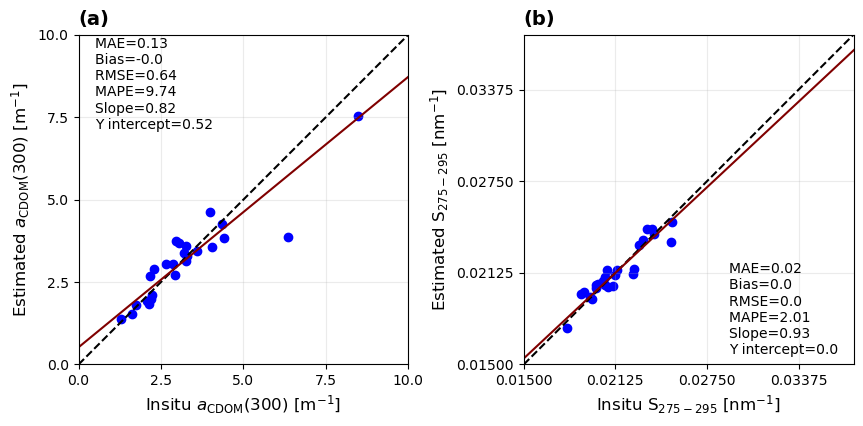

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs = axs.flatten()


axs[0].scatter(PB_data_for_mlr.ag300, PB_cdom_MSI, c='blue')


axs[0].plot(range(0, 11), range(0, 11), c='k', linestyle='--')
axs[0].grid(True, alpha=0.25)
axs[0].set_ylabel('Estimated $a_\mathrm{CDOM} (300)\ \mathrm{[m^{-1}]}$', fontsize=12)
axs[0].set_xlabel('Insitu $a_\mathrm{CDOM} (300)\ \mathrm{[m^{-1}]}$', fontsize=12)
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xticks(np.linspace(0, 10, 5))
axs[0].set_yticks(np.linspace(0, 10, 5))
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].set_ylim(0, 10)
axs[0].set_xlim(0, 10)

stats = regress2(PB_data_for_mlr.ag300, PB_cdom_MSI, _method_type_2="reduced major axis")
Y_fit = stats['slope'] * np.linspace(0, 11, 100) + stats['intercept']
axs[0].plot(np.linspace(0, 11, 100), Y_fit, c='maroon')

MAE, bias, RMSE, RMSLE, MAPE, MPD, N = algorithm_performance(PB_cdom_MSI, PB_data_for_mlr.ag300, rs_scale='linear', insitu_scale='linear')
axs[0].text(0.5, 8.5, f'MAE={MAE} \nBias={bias} \nRMSE={RMSE} \nMAPE={MAPE} \nSlope={np.round(stats["slope"],2)} \nY intercept={np.round(stats["intercept"],2)}', va='center')

###########################################################################################################################################################################
###########################################################################################################################################################################
###########################################################################################################################################################################
axs[1].scatter(PB_data_for_mlr.specslope, PB_specslope_MSI, c='blue')

axs[1].plot(np.arange(0.015, 0.05, 0.001), np.arange(0.015, 0.05, 0.001), c='k', linestyle='--')
axs[1].grid(True, alpha=0.25)
axs[1].set_ylabel('Estimated $\mathrm{S_{275-295}\ [nm^{-1}]}$', fontsize=12)
axs[1].set_xlabel('Insitu $\mathrm{S_{275-295}\ [nm^{-1}]}$', fontsize=12)
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xticks(np.linspace(0.015, 0.04, 5))
axs[1].set_yticks(np.linspace(0.015, 0.04, 5))
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].set_ylim(0.015, 0.0375)
axs[1].set_xlim(0.015, 0.0375)

stats = regress2(PB_data_for_mlr.specslope, PB_specslope_MSI, _method_type_2="reduced major axis")
Y_fit = stats['slope'] * np.arange(0.015, 0.05, 0.001) + stats['intercept']
axs[1].plot(np.arange(0.015, 0.05, 0.001), Y_fit, c='maroon')

MAE, bias, RMSE, RMSLE, MAPE, MPD, N = algorithm_performance(PB_specslope_MSI, PB_data_for_mlr.specslope, rs_scale='linear', insitu_scale='linear')
axs[1].text(0.029, 0.0155, f'MAE={MAE} \nBias={bias} \nRMSE={RMSE} \nMAPE={MAPE} \nSlope={np.round(stats["slope"],2)} \nY intercept={np.round(stats["intercept"],2)}', va='bottom')

# # Adjust horizontal and vertical spacing
plt.subplots_adjust(wspace=0.35, hspace=0.25)


subplot_labels = ['(a)', '(b)']
for ax, label in zip(axs, subplot_labels):
    ax.annotate(label, xy=(0, 1.075), xycoords='axes fraction', fontsize=14, fontweight='bold', va='top', ha='left')

plt.savefig(f'{fig_path}/SuppFig5_MSI_model_optimization.png',facecolor='w',bbox_inches='tight', dpi=300)

In [ ]:
ble = pd.read_csv("/.../BLE_LTER_DOC_TDN.csv",parse_dates=["date_time"])

In [ ]:
sag_lon_min = -148.3; sag_lon_max = -147.7
kup_lon_min = -149; kup_lon_max = -148.7
col_lon_min = -151.25; col_lon_max = -150.25

# Define the bounds for each river
col_bounds = {"lon_min": col_lon_min, "lon_max": col_lon_max,
              "lat_min": 70,"lat_max": 70.57}

kup_bounds = {"lon_min": kup_lon_min, "lon_max": kup_lon_max,
              "lat_min": 70, "lat_max": 70.5}

sag_bounds = {"lon_min": sag_lon_min, "lon_max": sag_lon_max,
              "lat_min": 70, "lat_max": 70.425,}



In [ ]:
ble.loc[(ble.lagoon=="Simpson") & (ble.date_time.dt.year==2021) & (ble.season != "under ice") & (ble.date_time.dt.month==8)].describe()

In [ ]:
ble.loc[(ble.longitude > sag_lon_min) & (ble.longitude < sag_lon_max) & (ble.date_time.dt.year==2021) & (ble.season != "under ice") & (ble.date_time.dt.month==8)].describe()

In [ ]:
ble_sag_2021 = ble.loc[(ble.longitude > sag_lon_min) & (ble.longitude < sag_lon_max) & (ble.date_time.dt.year==2021) & (ble.season != "under ice")].set_index("date_time")
ble_sag_2022 = ble.loc[(ble.longitude > sag_lon_min) & (ble.longitude < sag_lon_max) & (ble.date_time.dt.year==2022) & (ble.season != "under ice")].set_index("date_time")
sag_subset_21_daily = l2gen21.sel(lon=slice(sag_lon_min, sag_lon_max), lat=slice(70.425, 70))
sag_subset_22_daily = l2gen22.sel(lon=slice(sag_lon_min, sag_lon_max), lat=slice(70.425, 70))

years = [2021, 2022]


fig, axs = plt.subplots(1, 2, figsize=(16,9), sharey=True, sharex=True)
for ax,year in zip(axs, years):
    ax.plot(sag_discharge.loc[sag_discharge.index.year == year].index.dayofyear,
    sag_discharge.loc[sag_discharge.index.year == year].values,
    c="steelblue", linewidth=2)
    ax.set_xlim(100, 280)
    
    # Secondary y-axis for DOC
    ax2 = ax.twinx()
    if year==2021:
        ax2.scatter(sag_subset_21_daily.Date.dt.dayofyear, sag_subset_21_daily.doc.mean(dim=("lat", "lon"), skipna=True), c='m')
        ax2.scatter(ble_sag_2021.index.dayofyear, ble_sag_2021.dissolved_organic_carbon_umol_L, c="k")
    if year==2022:
        ax2.scatter(sag_subset_22_daily.Date.dt.dayofyear, sag_subset_22_daily.doc.mean(dim=("lat", "lon"), skipna=True), c='m')
        ax2.scatter(ble_sag_2022.index.dayofyear, ble_sag_2022.dissolved_organic_carbon_umol_L, c="k")


     # Add titles and labels
    ax.set_title(f"{year}", fontsize=14)
    if year==2021: ax.set_ylabel(f"Sag \nDischarge [$\mathrm{{m^3/s}}$]", fontsize=14)

    if year==2022: ax2.set_ylabel('DOC [$\mu \mathrm{M}$]', fontsize=14)
    ax.set_xlabel("Month", fontsize=14)
    ax.tick_params(axis='both', which='both', labelsize=12)
    ax2.tick_params(axis='both', which='both', labelsize=12)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b')) 
    ax.xaxis.set_major_locator(mdates.MonthLocator())


legend_elements = [Line2D([0], [0], color="steelblue", lw=2, label="Discharge"),
                    Line2D([0], [0], marker='o', color='m', linestyle='None', markersize=8, label="OLCI DOC"),
                    Line2D([0], [0], marker='o', color='k', linestyle='None', markersize=8, label="BLE LTER DOC")]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.05), fontsize=14, ncol=3, frameon=True)

fig.tight_layout()

plt.savefig(f'{fig_path}/SuppFig6_Sag_discharge_OLCI_LTER_DOC_2021_2022_.png',facecolor='w',bbox_inches='tight', dpi=300)